In [1]:
import numpy as np
import matplotlib.pyplot as plt
import read_chroma
import plot
import peak_detection
import projection
import peak_simulation
import random
import utils
import importlib
import sklearn
from sklearn.cluster import DBSCAN
import mass_spec
from skimage.segmentation import watershed
from scipy import ndimage as ndi
import integration
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import random
import baseline_correction
from skimage.restoration import estimate_sigma
from skimage.feature import peak_local_max
import benchmark_metrics
import matching

In [11]:
gt=benchmark_metrics.read_chromato_gt_json('G:/SIMULATION/simulation_strong_overlap.json')
peaks_mu=[]
for cluster in gt["peaks_mu"]:
    for peak in cluster:
        peaks_mu.append([peak[0], peak[1]])
peaks_mu=np.array(peaks_mu)

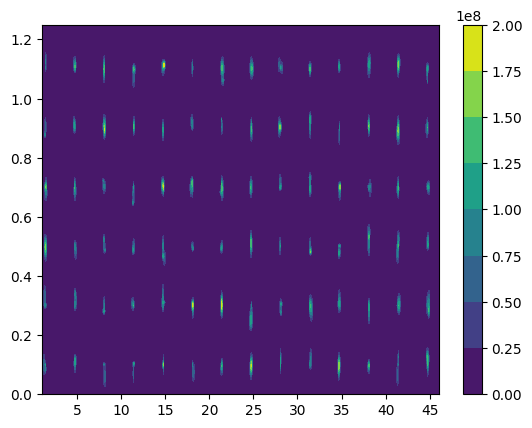

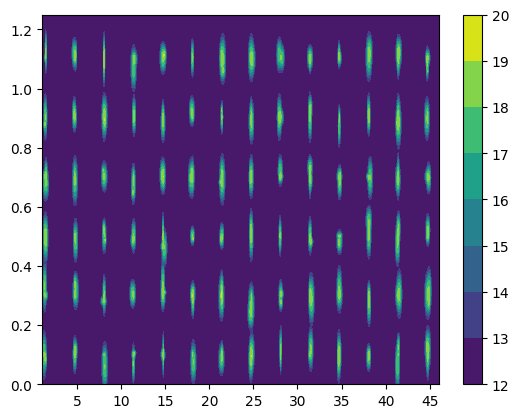

In [12]:
chromato_obj=read_chroma.read_chroma('G:/SIMULATION/simulation_strong_overlap.cdf',mod_time= 1.25)
chromato, time_rn, spectra_obj=chromato_obj
plot.visualizer(chromato_obj=(chromato,time_rn), log_chromato=False)
plot.visualizer(chromato_obj=(chromato,time_rn))

In [13]:
full_spectra = mass_spec.read_full_spectra_centroid(spectra_obj=spectra_obj)

--- 348.5519359111786 seconds --- to compute full spectra centroid


In [14]:
spectra, debuts, fins = full_spectra
chromato_cube = read_chroma.full_spectra_to_chromato_cube(full_spectra=full_spectra, spectra_obj=spectra_obj)
chromato = baseline_correction.chromato_no_baseline(chromato)
chromato_cube = np.array(baseline_correction.chromato_cube_corrected_baseline(chromato_cube))
sigma = estimate_sigma(chromato, channel_axis=None)
MIN_SEUIL = 5 * sigma * 100 / np.max(chromato)

# "benchmark" MCR-ALS

In [8]:
coordinates_3d_no_clust = peak_detection.peak_detection((chromato, time_rn, spectra_obj), spectra, chromato_cube, MIN_SEUIL, ABS_THRESHOLDS=0.01, method="peak_local_max", mode='3D', cluster=False)
len(coordinates_3d_no_clust)

362

In [9]:
hit_prob_min=0
match_factor_min=0
matches = matching.matching_nist_lib_from_chromato_cube((chromato, time_rn, spectra_obj), chromato_cube, coordinates_3d_no_clust, mod_time = 1.25, hit_prob_min=hit_prob_min, match_factor_min=match_factor_min)

nb_peaks:  362


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (�)-Fenchone: [-15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Camphor: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (-)-�-Camphor: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to p

nb match:
362


c:\Users\Stan\pic\matching.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(match)


In [10]:
retrieved_peaks=np.zeros_like(chromato_obj[0])
retrieved_cmp=np.full_like(chromato_obj[0], '', dtype='<U16')
for i, cd in enumerate(coordinates_3d_no_clust):
    retrieved_peaks[cd[0], cd[1]]+=1
    retrieved_cmp[cd[0], cd[1]]=matches[i][1]['compound_name']

In [11]:
peaks_gt, gt_cmp=benchmark_metrics.compute_gt('./SIMULATION/simulation_strong_overlap.json', chromato_obj)

In [12]:
len(np.argwhere((retrieved_cmp==gt_cmp) & (gt_cmp != ''))) / len(np.argwhere(gt_cmp != ''))

0.6504854368932039

In [13]:
coordinates_tic_plm = peak_detection.peak_detection((chromato, time_rn, spectra_obj), spectra, chromato_cube, MIN_SEUIL, ABS_THRESHOLDS=None, method="peak_local_max", mode='tic', cluster=False)
len(coordinates_tic_plm)

195

In [14]:
#utils
def tmp(chromato, coordinates, coordinate, threshold=0.25):
    mask = np.zeros(chromato.shape, dtype=bool)
    mask[tuple(coordinates.T)] = True
    markers, _ = ndi.label(mask)
    peak_apex_int = chromato[coordinate[0]][coordinate[1]]
    img = np.where(chromato < threshold * peak_apex_int, 0, 1)
    labels = watershed(-chromato, markers, mask=img)
    coordinate_label = labels[coordinate[0]][coordinate[1]]
    blob = np.where(labels != coordinate_label, 0, 1)
    cds = []
    for cd in np.argwhere(blob == 1):
        cds.append([cd[0], cd[1]])
    return cds

def compute_spectra_array(cds, chromato_cube):
    spc=[]
    for i,cd in enumerate(cds):
        spc.append(mass_spec.read_spectrum_from_chromato_cube(cd, chromato_cube=chromato_cube))
    return np.array(spc)

In [15]:
from pymcr.mcr import McrAR
import logging
import pyms_nist_search
import pyms
logger=logging.getLogger('pyms_nist_search')
logger.setLevel('ERROR')
logger=logging.getLogger('pyms')
logger.setLevel('ERROR')

In [29]:
retrieved_cmp_cpy=retrieved_cmp.copy()
(l1, l2, mv, iv, range_min, range_max) = spectra_obj
mass_values = np.linspace(range_min, range_max, range_max - range_min + 1).astype(int)
hit_p=[]
match_f=[]
for it, center_clust in enumerate(coordinates_tic_plm[:]):
    cds = np.array(tmp(chromato, coordinates_tic_plm, center_clust, threshold=0.3))
    sub_peak_list=[]
    for cd in cds:
        for cd_3d_plm in coordinates_3d_no_clust:
            if (cd[0] == cd_3d_plm[0] and cd[1] == cd_3d_plm[1]):
                sub_peak_list.append(cd_3d_plm)
    overlap=(len(sub_peak_list) > 1)
    if (overlap):
        spc=compute_spectra_array(cds, chromato_cube)
        mcrar = McrAR(max_iter=100)
        mcrar.fit(spc, ST=np.array([mass_spec.read_spectrum_from_chromato_cube(sub_peak, chromato_cube=chromato_cube) for sub_peak in sub_peak_list]))

        search = pyms_nist_search.Engine(
                "C:/NIST14/MSSEARCH/mainlib/",
                pyms_nist_search.NISTMS_MAIN_LIB,
                "C:/Users/Stan/Test")
        print(len(sub_peak_list))
        match_f.append(res[0][0].match_factor)
        hit_p.append(res[0][0].hit_prob)
        for k, sub_peak in enumerate(sub_peak_list):
            int_values=mcrar.ST_[k]
            mass_spectrum = pyms.Spectrum.MassSpectrum(mass_values, int_values)
            res = search.full_search_with_ref_data(mass_spectrum)
            retrieved_cmp_cpy[sub_peak[0], sub_peak[1]]=res[0][0].name
            
    print(it, "/", len(coordinates_tic_plm) - 1)
print(np.mean(match_f), np.mean(hit_p))


Error increased above fractionalctol_increase (C iter). Exiting
4
0 / 194
Error increased above fractionalctol_increase (C iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 1,3-Bis(�-aminopropyl)tetramethyldisiloxane, tetra-TMS: [-25].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 4'-Apo-�-carotenoic acid, all-trans-: [-25].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 4'-Apo-�-carotenoic acid: [-25].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


7


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Bicyclo[2.2.1]heptan-2-one, 1,7,7-trimethyl-, (�)-: [-15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (�)-Camphor: [-15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


1 / 194
Error increased above fractional tol_increase (ST iter). Exiting
3
2 / 194
Error increased above fractionalctol_increase (C iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Lanosta-8,24-dien-3-ol, (3�)-: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Lanosta-8,24-dien-3�-ol: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Cholesta-8,24-dien-3-ol, 4,4,14-trimethyl-, (3�,5�)-: [-31, -32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python3

5
3 / 194
Error increased above fractionalctol_increase (C iter). Exiting
4
4 / 194
Error increased above fractionalctol_increase (C iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Benzeneacetic acid, �,4-dihydroxy-, ethyl ester: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


4
5 / 194
Error increased above fractional tol_increase (ST iter). Exiting
5
6 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Benzyl alcohol, �-methyl-, acetate: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Methylbenzyl acetate: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Phenylethyl acetate: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_se

3
7 / 194
Error increased above fractionalctol_increase (C iter). Exiting
3
8 / 194
Max iterations reached (100).
2
9 / 194
Error increased above fractionalctol_increase (C iter). Exiting
3
10 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string N-�-Acetyl-L-Lysine, N,N-trimethylsilyl-, trimethylsilyl ester: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


2
11 / 194
Max iterations reached (100).
2
12 / 194
Error increased above fractionalctol_increase (C iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Coumarin, 3-(�-acetonylbenzyl)-4-hydroxy-: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 3-(�-Phenyl-�-acetylethyl)-4-hydroxycoumarin: [-32, -31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 3-(�-Phenyl-�-acetylaethyl)-4-hydroxycumarin: [-32, -31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData

6
13 / 194
Max iterations reached (100).
3
14 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Tetradecene: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Rheadan, 8-methoxy-16-methyl-2,3:10,11-bis[methylenebis(oxy)]-, (8�)-: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 8-�-Methoxy-16-methyl-2,3:10,11-bis(methylenebis(oxy))rheadan: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


Max iterations reached (100).
2
15 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Amino isobutyric acid tri-TMS II: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


Max iterations reached (100).
2
16 / 194
Error increased above fractionalctol_increase (C iter). Exiting
6
17 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (Z)-�-Farnesene: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-cis-Farnesene: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-(Z)-Farnesene: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: 

4
18 / 194
Error increased above fractional tol_increase (ST iter). Exiting
2
19 / 194
Error increased above fractionalctol_increase (C iter). Exiting
4
20 / 194
Error increased above fractionalctol_increase (C iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Fenchol: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Fenchyl alcohol: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Fenchyl acetate: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


7


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Hydroxyethyl phenyl ether: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Phenoxyethyl alcohol: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Phenoxyethanol: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.p

21 / 194
Error increased above fractional tol_increase (ST iter). Exiting
2
22 / 194
Max iterations reached (100).
2
23 / 194
Error increased above fractionalctol_increase (C iter). Exiting
4


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Nicotine: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Pyridyl-�-methylpyrrolidine: [-32, -32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (-)-�-Pyridyl-�-N-methylpyrrolidine: [-31, -32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_

24 / 194
Error increased above fractional tol_increase (ST iter). Exiting
2
25 / 194
Error increased above fractionalctol_increase (C iter). Exiting
3


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Pyridinecarboxylic acid: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Picolinaldehyde: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Indolylaldehyde: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


26 / 194
Error increased above fractionalctol_increase (C iter). Exiting
3
27 / 194
Error increased above fractionalctol_increase (C iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Cyclohexanol, 5-methyl-2-(1-methylethyl)-, [1S-(1�,2�,5�)]-: [-32, -31, -32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Terpineol, dihydro-: [-25].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Cyclohexanol, 5-methyl-2-(1-methylethyl)-, [1R-(1�,2�,5�)]-: [-32, -31, -32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c

2
28 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Amino-n-valeramide: [-21].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Aminovaleramide: [-21].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Piperidone: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarni

Max iterations reached (100).
2
29 / 194
Error increased above fractionalctol_increase (C iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 10H-Phenothiazine-10-propanamine, N,N,�-trimethyl-: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (�)-Alimemazine: [-15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (�)-Trimeprazine: [-15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nis

5
30 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (+)-�3-Carene: [-21].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Bicyclo[3.1.0]hexan-3-ol, 4-methyl-1-(1-methylethyl)-, acetate, (1�,3�,4�,5�)-: [-32, -32, -31, -32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string � 3-carene: [-21].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\

3
31 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 1,3,5,8-Tetramethyl-2,4-bis(�-hydroxyethyl)prophine-6,7-dipropionic acid: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Benzeneacetic acid, �-[(trimethylsilyl)oxy]-, trimethylsilyl ester: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Trimethylsilyl-�-(trimethylsiloxy)phenylacetae: [-32].
  warnings.warn(f"Unable to parse the following character codes for string 

2
32 / 194
Max iterations reached (100).
2
33 / 194
Error increased above fractionalctol_increase (C iter). Exiting
4


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (�)-3-Methyl-1-pentanol: [-15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


34 / 194
Error increased above fractionalctol_increase (C iter). Exiting
4
35 / 194
Error increased above fractionalctol_increase (C iter). Exiting
3
36 / 194
Error increased above fractionalctol_increase (C iter). Exiting
5
37 / 194
Error increased above fractionalctol_increase (C iter). Exiting
8


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Estr-4-en-3-one, 17-hydroxy-, (17�)-: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Estr-4-en-3-one, 17�-hydroxy-: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 4-Estren-17�-ol-3-one: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pym

38 / 194
Error increased above fractionalctol_increase (C iter). Exiting
4


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Methylpropyl phenyl acetate: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Isobutyl �-toluate: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


39 / 194
Max iterations reached (100).
2
40 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Nitro-�-naphthol: [-32, -31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 1-Nitro-�-naphthol: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


Max iterations reached (100).
2
41 / 194
42 / 194
Error increased above fractionalctol_increase (C iter). Exiting
3


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Vinylnaphthalene: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Resorcylaldehyde, 6-methyl-: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string N-Methyl-�-phenylsuccinimide: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_sear

43 / 194
Error increased above fractional tol_increase (ST iter). Exiting
4
44 / 194
Error increased above fractionalctol_increase (C iter). Exiting
2
45 / 194
Error increased above fractionalctol_increase (C iter). Exiting
3
46

c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Thujene: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Fellandrene: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Thujene: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to pars

 / 194
47 / 194
Error increased above fractionalctol_increase (C iter). Exiting
4
48 / 194
Error increased above fractionalctol_increase (C iter). Exiting
5


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Cyclopropaneacetic acid, �-amino-: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Cyclopropaneacetic acid, �-amino-, (�)-: [-32, -15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Aminocyclopropaneacetic acid: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\

49 / 194
Error increased above fractionalctol_increase (C iter). Exiting
2
50 / 194
Max iterations reached (100).
2
51 / 194
Error increased above fractional tol_increase (ST iter). Exiting
3
52 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Octyl alcohol: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 2-Octanol, (�)-: [-15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


5
53

c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Benzenemethanamine, �-methyl-, (�)-: [-32, -15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Benzylamine, �-methyl-, (�)-: [-32, -15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (�)-�-Methylbenzylamine: [-15, -32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\si

 / 194
Max iterations reached (100).
2
54 / 194
Error increased above fractional tol_increase (ST iter). Exiting
2


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Terpinen: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Terpinene: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Benzeneacetaldehyde, �-oxo-: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarnin

55 / 194
Error increased above fractionalctol_increase (C iter). Exiting
3
56 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Ketopropionaldehyde: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


Max iterations reached (100).
2
57 / 194
58 / 194
Error increased above fractionalctol_increase (C iter). Exiting
3
59

c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Methylpyridine: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Picoline: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Methylpyridine: [-25].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Una

 / 194
Max iterations reached (100).
2
60 / 194
Error increased above fractional tol_increase (ST iter). Exiting
4


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-(m-Hydroxyphenyl)propionic acid: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-(3-Hydroxyphenyl)propionic acid: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Carboline: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


61 / 194
Max iterations reached (100).
2
62 / 194
Error increased above fractionalctol_increase (C iter). Exiting
3
63 / 194
Error increased above fractional tol_increase (ST iter). Exiting
4
64 / 194
Error increased above fractionalctol_increase (C iter). Exiting
4
65 / 194
Error increased above fractionalctol_increase (C iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 5�Androstane, 17-ethyl-1,3-dihydroxy-, (1�3�)-: [-32, -31, -31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 2�,3�-epithio-17�-methyl-5�-androstan-17�-ol: [-32, -32, -32, -32, -31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Resorcylic acid, 6-(10-hydroxy-6-oxoundecyl)-, �-lactone (7CI): [-31, -26].
  warnings.warn(f"Unable to parse the following character codes for st

4
66 / 194
67 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string N-(�-Dimethylaminopropyl)iminodibenzyl: [-25].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


68 / 194
Error increased above fractional tol_increase (ST iter). Exiting
3
69 / 194
70 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �,�-Dimethyltrimethylene oxide: [-31, -31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


71 / 194
Error increased above fractional tol_increase (ST iter). Exiting
3
72 / 194
73 / 194
Error increased above fractional tol_increase (ST iter). Exiting
2
74 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (�)-trans-Carveol: [-15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �1,�-Cyclohexaneacetaldehyde, 3,3-dimethyl-, (E)-: [-21, -32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (E)-3,3-Dimethyl-�1,�-cyclohexaneacetaldehyde: [-21, -32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Py

2
75 / 194
Max iterations reached (100).
2
76 / 194
77 / 194
Max iterations reached (100).
2


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Quinoline: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Cyanostyrene: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Cyanostyrene: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable

78 / 194
79 / 194
80 / 194
Error increased above fractional tol_increase (ST iter). Exiting
2
81 / 194
82 / 194
Error increased above fractional tol_increase (ST iter). Exiting
2


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Cinchonan-9-ol, 6'-methoxy-, acetate (ester), (8�,9R)-: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


83 / 194
84 / 194
85 / 194
86 / 194
87 / 194
88 / 194
89 / 194
90 / 194
91 / 194
Max iterations reached (100).
2
92 / 194
93 / 194
94 / 194
95 / 194
96 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 2H-1-Benzopyran-2-one, 6-(�-D-glucopyranosyloxy)-7-hydroxy-: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 6-(�-D-Glucopyranosyloxy)-7-hydroxy-cumarin: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Esculetin 6-�-D-glucoside: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Progr

4
97 / 194
98 / 194
99 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Aminoisopropyl alcohol: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 2-Propanol, 1-amino-, (�)-: [-15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (�)-1-Amino-2-propanol: [-15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\

100 / 194
101 / 194
102 / 194
103 / 194
104 / 194
105 / 194
106 / 194
107 / 194
108 / 194
109 / 194
110 / 194
111 / 194
112 / 194
113 / 194
114 / 194
115 / 194
116 / 194
117 / 194
118 / 194
Max iterations reached (100).
2
119 / 194
Error increased above fractionalctol_increase (C iter). Exiting
4


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (�)-Fenchone: [-15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Camphor: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (-)-�-Camphor: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


120 / 194
121 / 194
122 / 194
Error increased above fractionalctol_increase (C iter). Exiting
3
123 / 194
Max iterations reached (100).
2
124 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 9,19-Cyclo-9�-lanost-24-en-3�-ol: [-31, -31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


Max iterations reached (100).
2
125 / 194
Error increased above fractional tol_increase (ST iter). Exiting
2
126 / 194
Max iterations reached (100).
2
127 / 194
Max iterations reached (100).
2
128 / 194
Max iterations reached (100).
2
129 / 194
130 / 194
Error increased above fractional tol_increase (ST iter). Exiting
2
131 / 194
132 / 194
133 / 194
134 / 194
Max iterations reached (100).
2
135 / 194
136 / 194
137 / 194
Max iterations reached (100).
2
138 / 194
139 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string L-�-Phenylglycine: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string L-(+)-�-Aminophenylacetic acid: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Benzeneacetic acid, �-amino-, (�S)-: [-32, -32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


140 / 194
141 / 194
Max iterations reached (100).
2
142 / 194
143 / 194
144 / 194
145 / 194
Max iterations reached (100).
2
146 / 194
147 / 194
148 / 194
149 / 194
150 / 194
151 / 194
152 / 194
153 / 194
154 / 194
Max iterations reached (100).
2
155 / 194
Max iterations reached (100).
2
156 / 194
157 / 194
158 / 194
159 / 194
160 / 194
Max iterations reached (100).
2
161 / 194
Max iterations reached (100).
2
162 / 194
163 / 194
Max iterations reached (100).
2
164 / 194
165 / 194
166 / 194
167 / 194
168 / 194
169 / 194
170 / 194
171 / 194
172 / 194
173 / 194
174 / 194
175 / 194
176 / 194
177 / 194
178 / 194
179 / 194
180 / 194
181 / 194
182 / 194
183 / 194
184 / 194
185 / 194
186 / 194
187 / 194
188 / 194
189 / 194
190 / 194
191 / 194
192 / 194
193 / 194
194 / 194
752.8709677419355 50.05967741935484


In [26]:
len(np.argwhere((retrieved_cmp==gt_cmp) & (gt_cmp != ''))) / len(np.argwhere(gt_cmp != '')), len(np.argwhere((retrieved_cmp_cpy==gt_cmp) & (gt_cmp != ''))) / len(np.argwhere(gt_cmp != ''))

(0.6504854368932039, 0.7038834951456311)

In [30]:
len(np.argwhere((retrieved_cmp_cpy==gt_cmp) & (gt_cmp != ''))) / len(np.argwhere(gt_cmp != ''))

0.7038834951456311

In [35]:
for i, cd in enumerate(np.argwhere((retrieved_cmp_cpy!=gt_cmp) & (gt_cmp != ''))):
    print(retrieved_cmp_cpy[cd[0], cd [1]], "---",  gt_cmp[cd[0], cd [1]])

D-Fenchone --- L-Fenchone
Heptane, 2,3,6-t --- Oxalic acid, but
1-Tridecanol, 12 --- 1-Tetradecanol
Benzoic acid, 3- --- Ethanone, 2-(for
2-Cyclohexen-1-o --- Î³-Terpinene
α-Phellandrene,  --- Î±-Phellandrene,
Gangaleoidin, TM --- Formic acid, but
Benzenemethanol, --- Phenol, 2-amino-
1-Cyclohexene, 1 --- p-Xylene
Benzaldehyde, 3- --- Benzaldehyde, 4-
Benzaldehyde, 4- --- Ethyl acetoaceta
Cyclohexanol, 3- --- 2-Butenal, 3-met
9H-Pyrido[3,4-b] --- Octanoic acid, e
1-Propanol --- 1-Pentanol
Cyclohexene, 4-m --- Î³-Terpinene
Hydroperoxide, h --- 1-Hexanol
 --- 1-Hexanol
2,3-Ethylone iso --- Diamide
1',1'-Dicarboeth --- Bicyclo[2.2.1]he
(+)-2-Bornanone --- Bicyclo[2.2.1]he
Bicyclo[2.2.1]he --- Propanoic acid, 
(E)-β-Farnesene --- (E)-Î²-Farnesene
Heptadecane, 2,6 --- Pentadecane
Triacetin --- Glycerol 1,2-dia
Cadaverine, 4TMS --- 3-Cyclopenten-1-
Allyl acetate --- 2,3-Butanedione
Fenchol --- N-(m-Toluoyl)gly
Glycerin --- N-[3-(1,3-Dimeth
Aniline --- Pyridine, 3-meth
Prochlorperazine --- 3-

Test other guess method

In [27]:
from sklearn.decomposition import NMF

In [28]:
retrieved_cmp_cpy=retrieved_cmp.copy()
(l1, l2, mv, iv, range_min, range_max) = spectra_obj
mass_values = np.linspace(range_min, range_max, range_max - range_min + 1).astype(int)

match_f=[]
hit_p=[]
for it, center_clust in enumerate(coordinates_tic_plm[:]):
    cds = np.array(tmp(chromato, coordinates_tic_plm, center_clust, threshold=0.3))
    sub_peak_list=[]
    for cd in cds:
        for cd_3d_plm in coordinates_3d_no_clust:
            if (cd[0] == cd_3d_plm[0] and cd[1] == cd_3d_plm[1]):
                sub_peak_list.append(cd_3d_plm)
    overlap=(len(sub_peak_list) > 1)
    if (overlap):
        spc=compute_spectra_array(cds, chromato_cube)
        mcrar = McrAR(max_iter=100)
        num_components=len(sub_peak_list)
        model=NMF(n_components=num_components, init="nndsvd", random_state=0)
        C=model.fit_transform(spc)
        S_T_guess=model.components_
        mcrar.fit(spc, ST=np.array(S_T_guess))
        search = pyms_nist_search.Engine(
                "C:/NIST14/MSSEARCH/mainlib/",
                pyms_nist_search.NISTMS_MAIN_LIB,
                "C:/Users/Stan/Test")
        print(len(sub_peak_list))
        match_f.append(res[0][0].match_factor)
        hit_p.append(res[0][0].hit_prob)
        for k, sub_peak in enumerate(sub_peak_list):
            int_values=mcrar.ST_[k]
            mass_spectrum = pyms.Spectrum.MassSpectrum(mass_values, int_values)
            res = search.full_search_with_ref_data(mass_spectrum)
            retrieved_cmp_cpy[sub_peak[0], sub_peak[1]]=res[0][0].name
            
    print(it, "/", len(coordinates_tic_plm) - 1)
    
print(len(np.argwhere((retrieved_cmp==gt_cmp) & (gt_cmp != ''))) / len(np.argwhere(gt_cmp != '')), len(np.argwhere((retrieved_cmp_cpy==gt_cmp) & (gt_cmp != ''))) / len(np.argwhere(gt_cmp != '')))
print(np.mean(hit_p), np.mean(match_f))

Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �,�-Dichloroacetophenone: [-22, -22].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


4
0 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Bicyclo[2.2.1]heptan-2-one, 1,7,7-trimethyl-, (�)-: [-15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (�)-Camphor: [-15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character co

7
1 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 9-�-D-Ribofuranosylxanthine: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-D-Ribofuranoside, xanthine-9: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 1H-Purine-2,6-dione, 3,9-dihydro-9-�-D-ribofuranosyl-: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python

3
2 / 194
Error increased above fractionalctol_increase (C iter). Exiting
5


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string N-(�-(4'-Methylpiperazinyl-1')propyl)-3-chlorophenothiazine: [-25].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-(4-(�-Hydroxyethyl)piperazin-1-yl)propyl-2-chlorophenothiazine: [-25, -31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


3 / 194
Error increased above fractional tol_increase (ST iter). Exiting
4


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Benzeneacetic acid, �,4-dihydroxy-, ethyl ester: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


4 / 194
Error increased above fractional tol_increase (ST iter). Exiting
4
5

c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Methyltoluene: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


 / 194
Error increased above fractional tol_increase (ST iter). Exiting
5


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Benzyl alcohol, �-methyl-, acetate: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Methylbenzyl acetate: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes f

6 / 194
Error increased above fractional tol_increase (ST iter). Exiting
3
7 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Error increased above fractionalctol_increase (C iter). Exiting
3


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Tolualdehyde: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Toluic aldehyde: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �2-Dihydropyran

8 / 194
Error increased above fractional tol_increase (ST iter). Exiting
2
9 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Error increased above fractional tol_increase (ST iter). Exiting
3


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string N-�-Acetyl-L-Lysine, N,N-trimethylsilyl-, trimethylsilyl ester: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


10 / 194
Error increased above fractional tol_increase (ST iter). Exiting
2
11 / 194
Max iterations reached (100).


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


2
12 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Coumarin, 3-(�-acetonylbenzyl)-4-hydroxy-: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 3-(�-Phenyl-�-acetylethyl)-4-hydroxycoumarin: [-32, -31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 3-(�-Phenyl-�-acetylaethyl)-4-hydroxycumarin: [-32, -31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData

6
13 / 194
Error increased above fractional tol_increase (ST iter). Exiting
3
14 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Rheadan, 8-methoxy-16-methyl-2,3:10,11-bis[methylenebis(oxy)]-, (8�)-: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 8-�-Methoxy-16-methyl-2,3:10,11-bis(methylenebis(oxy))rheadan: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Tetradecene: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\App

Max iterations reached (100).
2
15 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Amino isobutyric acid tri-TMS II: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


2
16 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (Z)-�-Farnesene: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-cis-Farnesene: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-(Z)-Farnesene:

6
17 / 194
Error increased above fractional tol_increase (ST iter). Exiting
4
18 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Furole: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Toluene, �-chloro-: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Chlorotoluene: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unab

Error increased above fractional tol_increase (ST iter). Exiting
2
19 / 194
Error increased above fractionalctol_increase (C iter). Exiting
4


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 2,7,7-Trimethylbicyclo[3.1.1]hept-2-en-6-yl, acetate, [1S-(1�,5�,6�)]-: [-32, -32, -31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Fenchol: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Fenchyl alcohol: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\l

20 / 194
Error increased above fractional tol_increase (ST iter). Exiting
7


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Hydroxyethyl phenyl ether: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Phenoxyethyl alcohol: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Phenoxyethanol: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.p

21 / 194
Error increased above fractional tol_increase (ST iter). Exiting
2
22 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Furole: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Phenylpropyl acetate: [-25].
  warnings.warn(f"Unable to parse the following character codes f

2
23 / 194
Error increased above fractional tol_increase (ST iter). Exiting
4


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (-)-�-Pyridyl-�-N-methylpyrrolidine: [-31, -32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Nicotine: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Pyridyl-�-methylpyrrolidine: [-32, -32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_

24 / 194
Error increased above fractional tol_increase (ST iter). Exiting
2
25 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (�)-Lavandulol: [-15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Geraniol: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Pyridinecarboxylic acid: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarni

3
26 / 194
Error increased above fractional tol_increase (ST iter). Exiting
3
27 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Cyclohexanol, 5-methyl-2-(1-methylethyl)-, [1S-(1�,2�,5�)]-: [-32, -31, -32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Terpineol, dihydro-: [-25].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Cyclohexanol, 5-methyl-2-(1-methylethyl)-, [1R-(1�,2�,5�)]-: [-32, -31, -32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c

2
28 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


2
29 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 10H-Phenothiazine-10-propanamine, N,N,�-trimethyl-: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (�)-Alimemazine: [-15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (�)-Trimeprazine: [-15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nis

5
30 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-2-Carene: [-21].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (�)-2-Carene: [-15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 7-(�,�-Dihydroxypropyl)theophylline: [-31, -25].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


3
31 / 194
Error increased above fractional tol_increase (ST iter). Exiting
2
32 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Benzeneacetic acid, �-[(trimethylsilyl)oxy]-, trimethylsilyl ester: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Trimethylsilyl-�-(trimethylsiloxy)phenylacetae: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Caprylic acid, �-methyl-: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


Max iterations reached (100).
2
33 / 194
Error increased above fractionalctol_increase (C iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (�)-3-Methyl-1-pentanol: [-15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


4
34 / 194
Error increased above fractionalctol_increase (C iter). Exiting
4
35 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Butyrolactone: [-25].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-BL: [-25].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Hydroxybutyric acid cycli

3
36 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Hydroxyethyl phenyl ether: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Phenoxyethyl alcohol: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for stri

5
37 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Estr-4-en-3-one, 17-hydroxy-, (17�)-: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Estr-4-en-3-one, 17�-hydroxy-: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following characte

8
38 / 194
Error increased above fractional tol_increase (ST iter). Exiting
4
39 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Methylpropyl phenyl acetate: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Isobutyl �-toluate: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


2
40 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Nitro-�-naphthol: [-32, -31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 1-Nitro-�-naphthol: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


Max iterations reached (100).
2
41 / 194
42 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Vinylnaphthalene: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


Max iterations reached (100).
3
43 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string N-Methyl-�-phenylsuccinimide: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (�)-N-Methyl-2-phenylsuccinimide: [-15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Phenylglutarimide: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_

4
44 / 194
Error increased above fractional tol_increase (ST iter). Exiting
2
45 / 194
Error increased above fractional tol_increase (ST iter). Exiting
3


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Fellandrene: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Thujene: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Thujene, �-: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to pa

46 / 194
47 / 194
Error increased above fractionalctol_increase (C iter). Exiting
4
48 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Cyclopropaneacetic acid, �-amino-: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Cyclopropaneacetic acid, �-amino-, (�)-: [-32, -15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the follow

Error increased above fractional tol_increase (ST iter). Exiting
5


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


49 / 194
Error increased above fractionalctol_increase (C iter). Exiting
2
50 / 194
Max iterations reached (100).
2
51 / 194
Error increased above fractionalctol_increase (C iter). Exiting
3
52 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Octyl alcohol: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 2-Octanol, (�)-: [-15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Benzenemethanami

5
53 / 194
Max iterations reached (100).


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


2
54 / 194
Error increased above fractional tol_increase (ST iter). Exiting
2
55 / 194
Error increased above fractionalctol_increase (C iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Terpinen: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Terpinene: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Terpinen: [-25].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to pars

3
56 / 194
Error increased above fractional tol_increase (ST iter). Exiting
2
57 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Ketopropionaldehyde: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Methylpyridine: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Picolin

58 / 194
Error increased above fractionalctol_increase (C iter). Exiting
3


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Ureidoisobutyrate, N,O-bis(trimethylsilyl) deriv.: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Benzeneethanamine, N,�-dimethyl-, (S)-: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to pars

59 / 194
Max iterations reached (100).
2
60 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-(m-Hydroxyphenyl)propionic acid: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-(3-Hydroxyphenyl)propionic acid: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


4
61 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Carboline: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Ethyl �-methylvalerate: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


2
62 / 194
Max iterations reached (100).
3
63 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Vinylnaphthalene: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Error increased above fractional tol_increase (ST iter). Exiting
4
64 / 194
Error increased above fractional tol_increase (ST iter). Exiting
4


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 5�Androstane, 17-ethyl-1,3-dihydroxy-, (1�3�)-: [-32, -31, -31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 2�,3�-epithio-17�-methyl-5�-androstan-17�-ol: [-32, -32, -32, -32, -31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


65 / 194
Error increased above fractionalctol_increase (C iter). Exiting
4


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string N-(�-Dimethylaminopropyl)iminodibenzyl: [-25].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


66 / 194
67 / 194
68 / 194
Error increased above fractionalctol_increase (C iter). Exiting
3


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �,�-Dimethyltrimethylene oxide: [-31, -31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


69 / 194
70 / 194
71 / 194
Error increased above fractionalctol_increase (C iter). Exiting
3
72 / 194
73 / 194
Error increased above fractional tol_increase (ST iter). Exiting
2
74 / 194
Error increased above fractional tol_increase (ST iter). Exiting
2
75

c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (�)-trans-Carveol: [-15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �1,�-Cyclohexaneacetaldehyde, 3,3-dimethyl-, (E)-: [-21, -32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (E)-3,3-Dimethyl-�1,�-cyclohexaneacetaldehyde: [-21, -32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Py

 / 194
Max iterations reached (100).
2
76 / 194
77 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Quinoline: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Cyanostyrene: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Cyanostyrene: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable

2
78 / 194
79 / 194
80 / 194
Error increased above fractional tol_increase (ST iter). Exiting
2
81 / 194
82 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Cinchonan-9-ol, 6'-methoxy-, acetate (ester), (8�,9R)-: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


2
83 / 194
84 / 194
85 / 194
86 / 194
87 / 194
88 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Fenchol: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Fenchyl alcohol: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Fenchyl acetate: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


89 / 194
90 / 194
91 / 194
Max iterations reached (100).
2
92 / 194
93 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 2H-1-Benzopyran-2-one, 6-(�-D-glucopyranosyloxy)-7-hydroxy-: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 6-(�-D-Glucopyranosyloxy)-7-hydroxy-cumarin: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Esculetin 6-�-D-glucoside: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Progr

94 / 194
95 / 194
96 / 194
Error increased above fractional tol_increase (ST iter). Exiting
4
97 / 194
98 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Aminoisopropyl alcohol: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 2-Propanol, 1-amino-, (�)-: [-15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (�)-1-Amino-2-propanol: [-15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\

99 / 194
100 / 194
101 / 194
102 / 194
103 / 194
104 / 194
105 / 194
106 / 194
107 / 194
108 / 194
109 / 194
110 / 194
111 / 194
112 / 194
113 / 194
114 / 194
115 / 194
116 / 194
117 / 194
118 / 194
Error increased above fractional tol_increase (ST iter). Exiting
2
119 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Carboline: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (�)-Fenchone: [-15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Camphor: [-31].
  war

4
120 / 194
121 / 194
122 / 194
Error increased above fractional tol_increase (ST iter). Exiting
3


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


123 / 194
Max iterations reached (100).
2
124 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Lanosta-8,24-dien-3-ol, (3�)-: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Lanosta-8,24-dien-3�-ol: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Cholesta-8,24-dien-3-ol, 4,4,14-trimethyl-, (3�,5�)-: [-31, -32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python3

Error increased above fractional tol_increase (ST iter). Exiting
2
125 / 194
Error increased above fractional tol_increase (ST iter). Exiting
2
126 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Lanosta-8,24-dien-3-ol, (3�)-: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Lanosta-8,24-dien-3�-ol: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Cholesta-8,24-dien-3-ol, 4,4,14-trimethyl-, (3�,5�)-: [-31, -32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python3

Max iterations reached (100).
2
127 / 194
Error increased above fractional tol_increase (ST iter). Exiting
2


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


128 / 194
Error increased above fractional tol_increase (ST iter). Exiting
2


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Ergoline-8�-carboxamide, 1-acetyl-9,10-didehydro-N,N-diethyl-6-methyl-: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")


129 / 194
130 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


2
131 / 194
132 / 194
133 / 194
134 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (R)-�-Methylbenzenemethanamine: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Benzenemethanamine, �-methyl-, (�)-: [-32, -15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following cha

2
135 / 194
136 / 194
137 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Max iterations reached (100).
2
138 / 194
139 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Benzenemethanamine, �-methyl-, (�)-: [-32, -15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Benzylamine, �-methyl-, (�)-: [-32, -15].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string (�)-�-Methylbenzylamine: [-15, -32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\si

140 / 194
141 / 194
Error increased above fractional tol_increase (ST iter). Exiting
2
142 / 194
143 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Furole: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Toluene, �-chloro-: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Chlorotoluene: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unab

144 / 194
145 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


2
146 / 194
147 / 194
148 / 194
149 / 194
150 / 194
151 / 194
152 / 194
153 / 194
154 / 194
Error increased above fractional tol_increase (ST iter). Exiting
2


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Methylpyridine: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Picoline: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Methylpyridine: [-

155 / 194
Error increased above fractional tol_increase (ST iter). Exiting


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Methylpyridine: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Picoline: [-31].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Methylpyridine: [-

2
156 / 194
157 / 194
158 / 194
159 / 194
160 / 194
Error increased above fractional tol_increase (ST iter). Exiting
2
161 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Furole: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string Toluene, �-chloro-: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Chlorotoluene: [-32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unab

Max iterations reached (100).
2
162 / 194
163 / 194


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Max iterations reached (100).
2
164 / 194
165 / 194
166 / 194
167 / 194
168 / 194
169 / 194
170 / 194
171 / 194
172 / 194
173 / 194
174 / 194
175 / 194
176 / 194
177 / 194
178 / 194
179 / 194
180 / 194
181 / 194
182 / 194
183 / 194
184 / 194
185 / 194
186 / 194
187 / 194
188 / 194
189 / 194
190 / 194
191 / 194
192 / 194
193 / 194
194 / 194
0.6504854368932039 0.45145631067961167
54.000215053763455 790.1612903225806


In [ ]:
center_pt=[100,100]

# Mass per mass

In [15]:
coordinates = peak_detection.peak_detection((chromato, time_rn, spectra_obj), spectra, chromato_cube, MIN_SEUIL, ABS_THRESHOLDS=0.5, method="peak_local_max", mode='mass_per_mass', cluster=True)

c:\Users\Stan\pic\peak_detection.py:88: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clusters = np.array(clusters)


In [16]:
coordinates_no_clust = peak_detection.peak_detection((chromato, time_rn, spectra_obj), spectra, chromato_cube, MIN_SEUIL, ABS_THRESHOLDS=0.7, method="peak_local_max", mode='mass_per_mass', cluster=False, unique=False)
coordinates_no_clust_in_chromato=projection.matrix_to_chromato(np.unique(coordinates_no_clust, axis=0), time_rn, 1.25, chromato.shape)

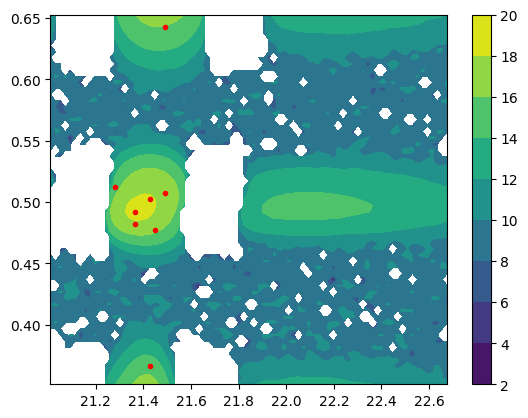

In [31]:
plot.visualizer(chromato_obj=(chromato,time_rn), points=coordinates_no_clust_in_chromato, center_pt=center_pt, center_pt_window_1=40, center_pt_window_2=30)

In [34]:
histogram=np.zeros_like(chromato, dtype=int)
for cd in coordinates_no_clust:
    histogram[cd[0], cd[1]]+=1
np.min(histogram), np.max(histogram), len(np.argwhere(histogram) != 0)

(0, 103, 1020)

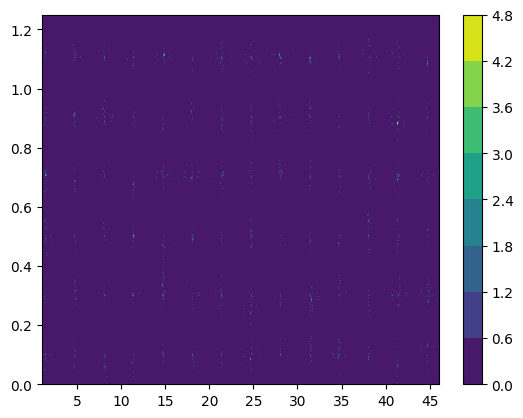

In [35]:
plot.visualizer(chromato_obj=(histogram + 1,time_rn), log_chromato=True)

In [38]:
u_hist=(peak_local_max(histogram, threshold_abs=2))
u_hist_in_chromato=projection.matrix_to_chromato(u_hist, time_rn=time_rn, mod_time=1.25, chromato_dim=chromato.shape)
print(len(u_hist))

65


In [39]:
filtered_u_hist = np.array(
        [[x, y] for x, y in u_hist if chromato[x, y] > MIN_SEUIL * np.max(chromato)])
filtered_u_hist_in_chromato=projection.matrix_to_chromato(filtered_u_hist, time_rn, 1.25, chromato.shape)
len(u_hist), len(filtered_u_hist)

(65, 65)

In [40]:
center_pt=[1000,100]

In [62]:
u_hist_in_chromato

array([[41.33112991,  0.88353414],
       [11.42148064,  0.50200803],
       [14.88141219,  1.11445783],
       [27.94994884,  1.11445783],
       [ 1.47938817,  0.70783133],
       [31.43072336,  1.10441767],
       [24.71928986,  0.08534137],
       [31.59746705,  0.28614458],
       [44.72853258,  1.08433735],
       [41.39365879,  0.69277108],
       [24.76097578,  1.10441767],
       [21.426102  ,  0.30120482],
       [11.40063768,  0.67771084],
       [ 4.68920418,  0.91365462],
       [34.76559714,  1.10441767],
       [14.73551147,  0.33634538],
       [28.09584957,  0.10040161],
       [21.426102  ,  1.10441767],
       [44.89527627,  0.2811245 ],
       [ 8.08660685,  1.10441767],
       [38.10047093,  0.50200803],
       [44.70768962,  0.13052209],
       [17.96617045,  0.69779116],
       [18.02869933,  0.92369478],
       [24.74013282,  0.51706827],
       [14.75635443,  0.30120482],
       [41.43534472,  0.70281124],
       [28.09584957,  1.10441767],
       [31.43072336,

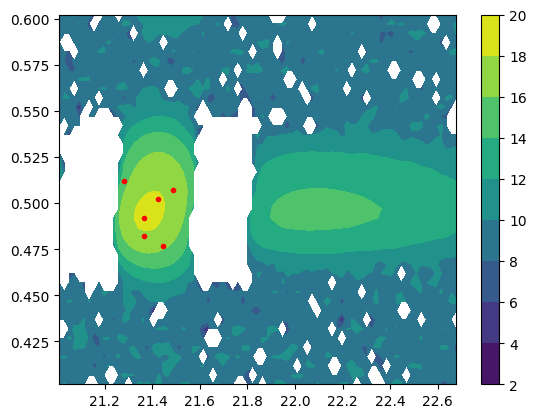

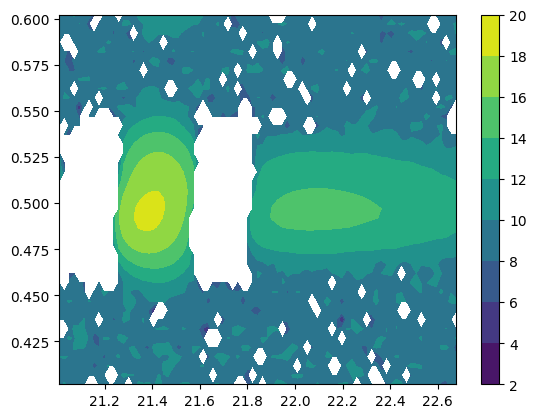

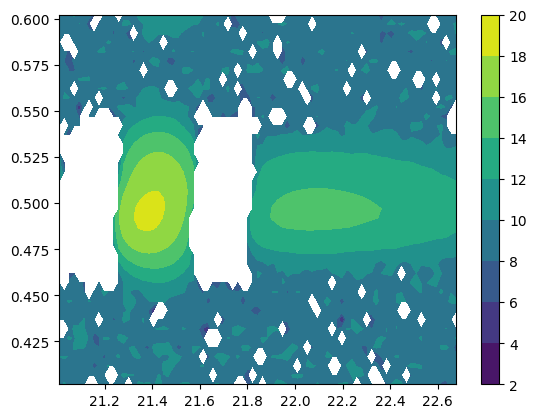

In [42]:
plot.visualizer(chromato_obj=(chromato,time_rn), points=coordinates_no_clust_in_chromato, center_pt=center_pt, center_pt_window_1=40, center_pt_window_2=20)
plot.visualizer(chromato_obj=(chromato,time_rn), points=u_hist_in_chromato, center_pt=center_pt, center_pt_window_1=40, center_pt_window_2=20)
plot.visualizer(chromato_obj=(chromato,time_rn), points=filtered_u_hist_in_chromato, center_pt=center_pt, center_pt_window_1=40, center_pt_window_2=20)

In [43]:
peaks_mu_in_chromato=projection.matrix_to_chromato(peaks_mu, time_rn, 1.25, chromato.shape)

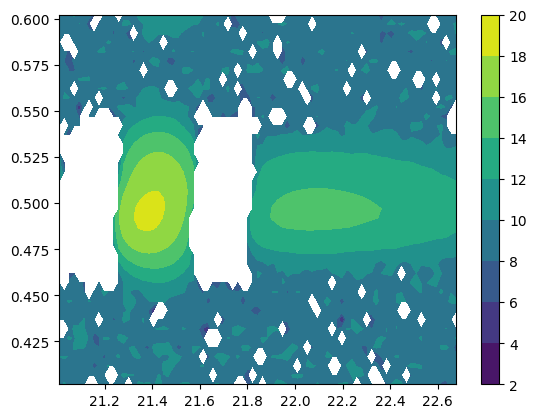

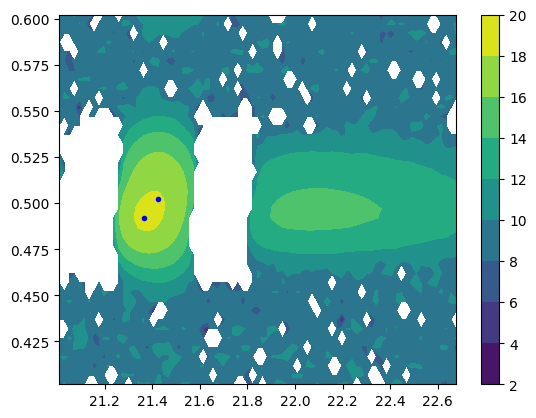

In [44]:
plot.visualizer(chromato_obj=(chromato,time_rn), points=filtered_u_hist_in_chromato, center_pt=center_pt, center_pt_window_1=40, center_pt_window_2=20)
plot.visualizer(chromato_obj=(chromato,time_rn), contour=peaks_mu_in_chromato, points=filtered_u_hist_in_chromato, center_pt=center_pt, center_pt_window_1=40, center_pt_window_2=20)

# 3D

In [45]:
coordinates_3d = peak_detection.peak_detection((chromato, time_rn, spectra_obj), spectra, chromato_cube, MIN_SEUIL, ABS_THRESHOLDS=0.01, method="peak_local_max", mode='3D')

c:\Users\Stan\pic\peak_detection.py:88: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clusters = np.array(clusters)


In [46]:
coordinates_3d_in_chromato=projection.matrix_to_chromato(np.unique(coordinates_3d, axis=0), time_rn, 1.25, chromato.shape)

c:\Users\Stan\pic\plot.py:356: RuntimeWarning: divide by zero encountered in log
  chromato = np.log(chromato)


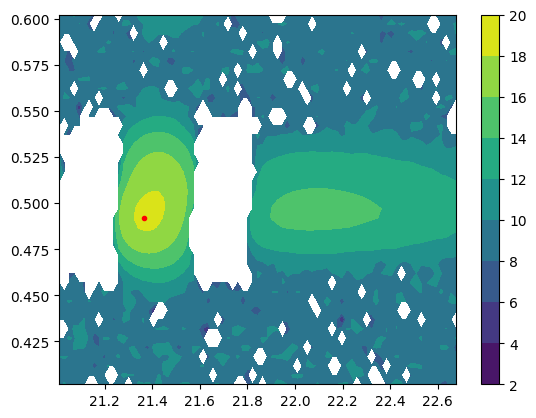

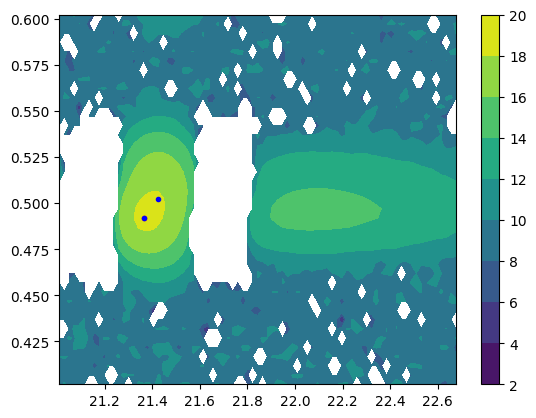

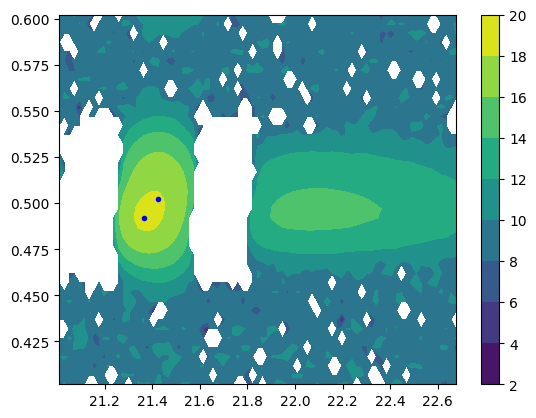

In [47]:
plot.visualizer(chromato_obj=(chromato,time_rn), points=coordinates_3d_in_chromato, center_pt=center_pt, center_pt_window_1=40, center_pt_window_2=20)
plot.visualizer(chromato_obj=(chromato,time_rn), contour=peaks_mu_in_chromato, points=coordinates_3d_in_chromato, center_pt=center_pt, center_pt_window_1=40, center_pt_window_2=20)
plot.visualizer(chromato_obj=(chromato,time_rn), contour=peaks_mu_in_chromato, center_pt=center_pt, center_pt_window_1=40, center_pt_window_2=20)

In [48]:
coordinates_3d_no_clust = peak_detection.peak_detection((chromato, time_rn, spectra_obj), spectra, chromato_cube, MIN_SEUIL, ABS_THRESHOLDS=0.01, method="peak_local_max", mode='3D', cluster=False)
coordinates_3d_no_clust_in_chromato=projection.matrix_to_chromato(np.unique(coordinates_3d_no_clust, axis=0), time_rn, 1.25, chromato.shape)

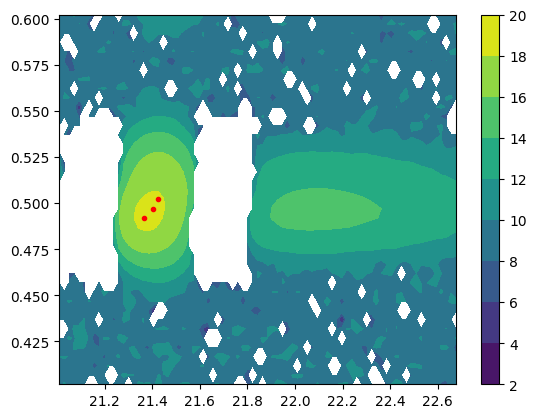

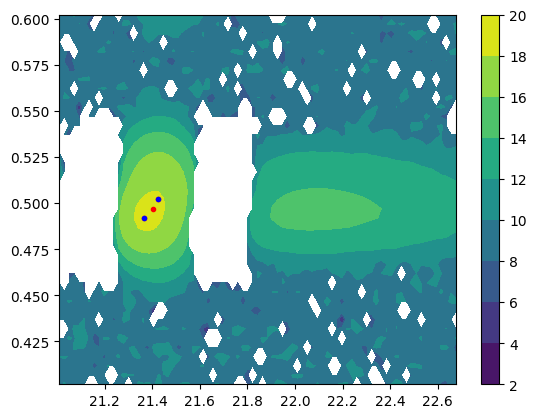

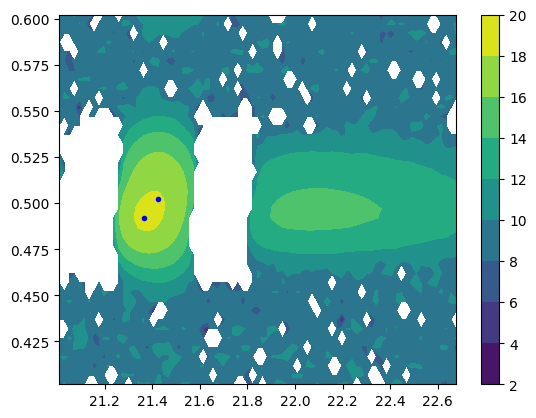

In [49]:
plot.visualizer(chromato_obj=(chromato,time_rn), points=coordinates_3d_no_clust_in_chromato, center_pt=center_pt, center_pt_window_1=40, center_pt_window_2=20)
plot.visualizer(chromato_obj=(chromato,time_rn), contour=peaks_mu_in_chromato, points=coordinates_3d_no_clust_in_chromato, center_pt=center_pt, center_pt_window_1=40, center_pt_window_2=20)
plot.visualizer(chromato_obj=(chromato,time_rn), contour=peaks_mu_in_chromato, center_pt=center_pt, center_pt_window_1=40, center_pt_window_2=20)

In [50]:
len(coordinates_3d_in_chromato), len(coordinates_3d_no_clust_in_chromato)

(224, 362)

In [51]:
coordinates_3d_no_clust_no_unique = peak_detection.peak_detection((chromato, time_rn, spectra_obj), spectra, chromato_cube, MIN_SEUIL, ABS_THRESHOLDS=0.01, method="peak_local_max", mode='3D', cluster=False, unique=False)
coordinates_3d_no_clust_no_unique_in_chromato=projection.matrix_to_chromato(np.unique(coordinates_3d_no_clust_no_unique, axis=0), time_rn, 1.25, chromato.shape)

In [52]:
len(coordinates_3d_no_clust_no_unique), len(np.unique(coordinates_3d_no_clust_no_unique))

(2054, 244)

In [53]:
histogram3d=np.zeros_like(chromato, dtype=int)
for cd in coordinates_3d_no_clust_no_unique:
    histogram3d[cd[0], cd[1]]+=1
print(np.max(histogram3d))

27


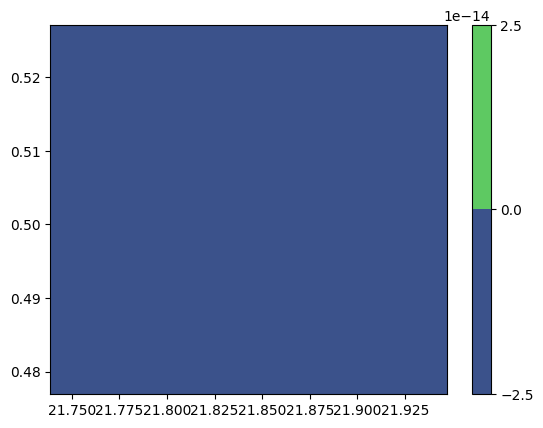

In [54]:
plot.visualizer(chromato_obj=(histogram3d,time_rn), log_chromato=False,  center_pt=center_pt, center_pt_window_1=5, center_pt_window_2=5)

In [55]:
u_hist_3d=(peak_local_max(histogram3d, threshold_abs=2))
u_hist_3d_in_chromato=projection.matrix_to_chromato(u_hist_3d, time_rn=time_rn, mod_time=1.25, chromato_dim=chromato.shape)
print(len(u_hist_3d))

201


In [56]:
filtered_u_hist_3d = np.array(
        [[x, y] for x, y in u_hist_3d if chromato[x, y] > MIN_SEUIL * np.max(chromato)])
filtered_u_hist_3d_in_chromato=projection.matrix_to_chromato(filtered_u_hist_3d, time_rn, 1.25, chromato.shape)
len(filtered_u_hist_3d), len(filtered_u_hist_3d_in_chromato)

(201, 201)

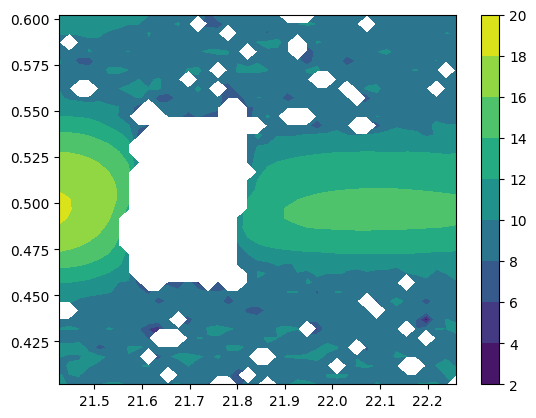

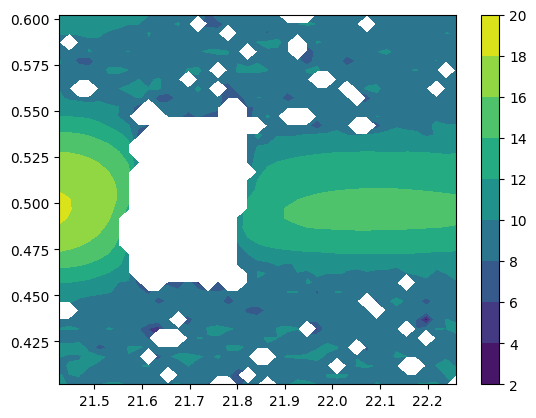

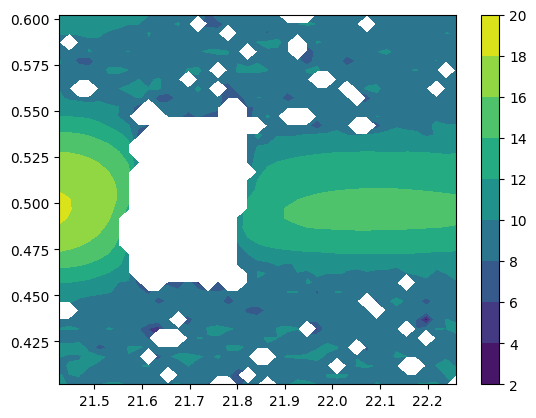

In [57]:
plot.visualizer(chromato_obj=(chromato,time_rn), points=coordinates_3d_no_clust_in_chromato, center_pt=center_pt, center_pt_window_1=20, center_pt_window_2=20)
plot.visualizer(chromato_obj=(chromato,time_rn), points=u_hist_3d_in_chromato, center_pt=center_pt, center_pt_window_1=20, center_pt_window_2=20)
plot.visualizer(chromato_obj=(chromato,time_rn), points=filtered_u_hist_3d_in_chromato, center_pt=center_pt, center_pt_window_1=20, center_pt_window_2=20)

In [58]:
peaks_mu_in_chromato

array([[ 1.41685928,  0.10040161],
       [ 1.41685928,  0.08534137],
       [ 1.25011559,  0.10040161],
       [ 1.41685928,  0.30120482],
       [ 1.33348744,  0.3313253 ],
       [ 1.41685928,  0.50200803],
       [ 1.43770224,  0.49196787],
       [ 1.41685928,  0.70281124],
       [ 1.47938817,  0.70783133],
       [ 1.4585452 ,  0.67771084],
       [ 1.41685928,  0.90361446],
       [ 1.3543304 ,  0.87851406],
       [ 1.41685928,  1.10441767],
       [ 1.4585452 ,  1.12449799],
       [ 4.75173307,  0.10040161],
       [ 4.81426195,  0.11546185],
       [ 4.75173307,  0.30120482],
       [ 4.85594787,  0.31626506],
       [ 4.79341899,  0.34136546],
       [ 4.75173307,  0.50200803],
       [ 4.83510491,  0.48694779],
       [ 4.75173307,  0.70281124],
       [ 4.77257603,  0.687751  ],
       [ 4.75173307,  0.90361446],
       [ 4.68920418,  0.91365462],
       [ 4.75173307,  1.10441767],
       [ 4.68920418,  1.11947791],
       [ 4.81426195,  1.11445783],
       [ 8.08660685,

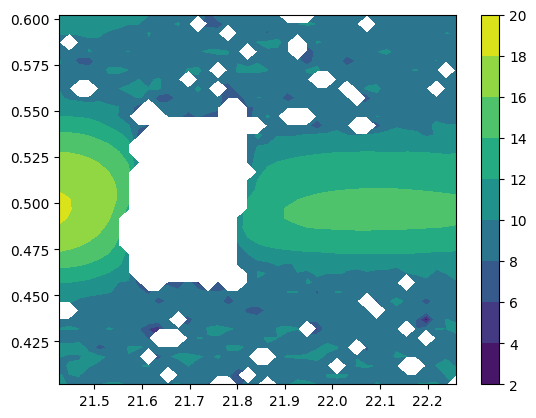

In [59]:
plot.visualizer(chromato_obj=(chromato,time_rn), points=coordinates_3d_no_clust_in_chromato, center_pt=center_pt, center_pt_window_1=20, center_pt_window_2=20)

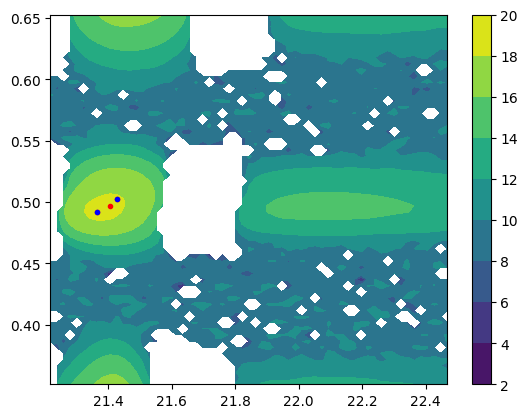

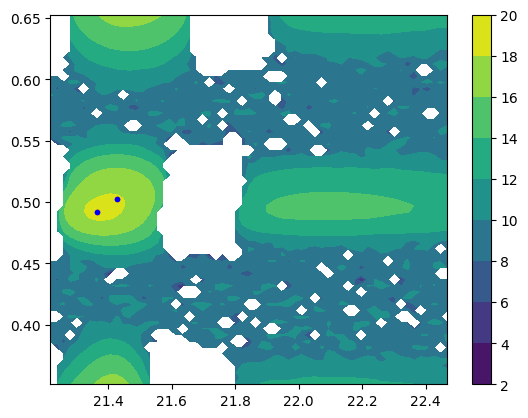

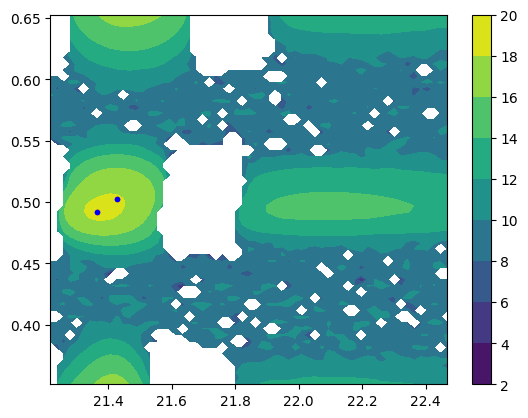

In [60]:
plot.visualizer(chromato_obj=(chromato,time_rn), contour=peaks_mu_in_chromato, points=coordinates_3d_no_clust_in_chromato, center_pt=center_pt, center_pt_window_1=30, center_pt_window_2=30)
plot.visualizer(chromato_obj=(chromato,time_rn), contour=peaks_mu_in_chromato,points=u_hist_3d_in_chromato, center_pt=center_pt, center_pt_window_1=30, center_pt_window_2=30)
plot.visualizer(chromato_obj=(chromato,time_rn), contour=peaks_mu_in_chromato,points=filtered_u_hist_3d_in_chromato, center_pt=center_pt, center_pt_window_1=30, center_pt_window_2=30)

# GC-MS vs GCxGC-MS

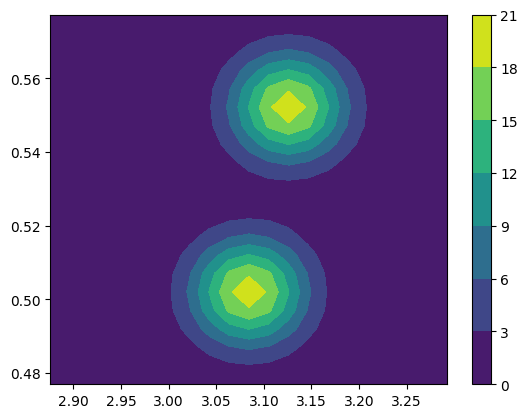

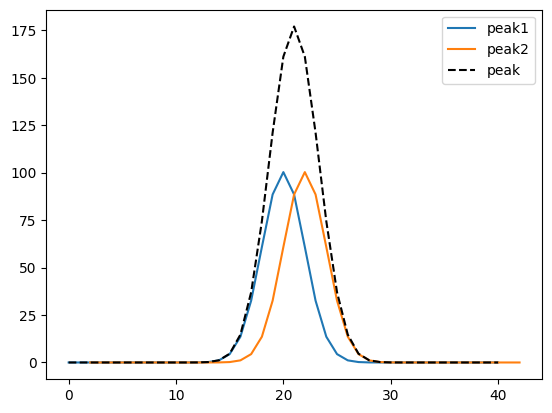

In [108]:
import peak_simulation

chromato_cpy=np.zeros_like(chromato)
size=20
offset=2
peak=peak_simulation.create_peak(size, 20, sigma=2.0, random_noise=False)
chromato_cpy=peak_simulation.add_peak(chromato_cpy, peak, [100,100])
peak2=peak_simulation.create_peak(size, 20, sigma=2.0, random_noise=False)
chromato_cpy=peak_simulation.add_peak(chromato_cpy, peak2, [100+offset,110])
plot.visualizer((chromato_cpy, time_rn), log_chromato=False, center_pt=[100, 105], center_pt_window_1=10, center_pt_window_2=10)

plt.plot(np.linspace(0, 2*size, 2*size +1), np.sum(peak, axis=-1), label="peak1")
plt.plot(np.linspace(0+offset, 2*size+offset, 2*size +1), np.sum(peak2, axis=-1), label="peak2")
plt.plot(np.linspace(0, 2*size, 2*size+1), np.sum(chromato_cpy, axis=-1)[100-size:100+size+1], label="peak", linestyle='dashed', color="black")
plt.legend()

In [115]:
importlib.reload(plot)

<module 'plot' from 'c:\\Users\\Stan\\pic\\plot.py'>

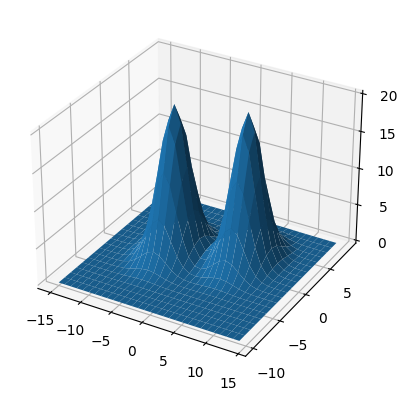

In [120]:
plot.plot_3d_chromato(chromato_cpy[90:110, 90:120],plot_map=False, rstride=1, cstride=1)

# Test integration overlaped peaks WATERSHED and Test Area

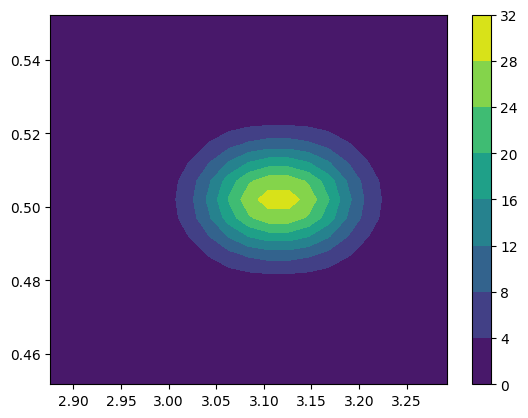

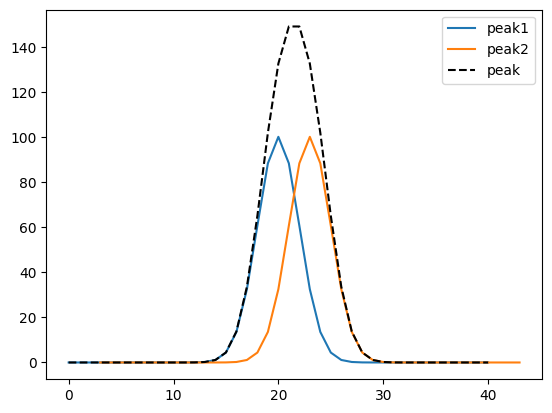

In [10]:
import peak_simulation

chromato_cpy=np.zeros_like(chromato)
size=20
offset=3
peak=peak_simulation.create_peak(size, 20, sigma=2.0, random_noise=False)
chromato_cpy=peak_simulation.add_peak(chromato_cpy, peak, [100,100])
peak2=peak_simulation.create_peak(size, 20, sigma=2.0, random_noise=False)
chromato_cpy=peak_simulation.add_peak(chromato_cpy, peak2, [100+offset,100])
plot.visualizer((chromato_cpy, time_rn), log_chromato=False, center_pt=[100, 100], center_pt_window_1=10, center_pt_window_2=10)

plt.plot(np.linspace(0, 2*size, 2*size +1), np.sum(peak, axis=-1), label="peak1")
plt.plot(np.linspace(0+offset, 2*size+offset, 2*size +1), np.sum(peak2, axis=-1), label="peak2")
plt.plot(np.linspace(0, 2*size, 2*size+1), np.sum(chromato_cpy, axis=-1)[100-size:100+size+1], label="peak", linestyle='dashed', color="black")
plt.legend()

In [161]:
from matchms.importing import load_from_mgf, scores_from_json
import logging
from mass_spec import centroid_to_full_nominal

pt1=[100,100]

pt2=[104,100]

importlib.reload(peak_simulation)
logger=logging.getLogger('matchms')
logger.setLevel('ERROR')
lib_spectra=list(load_from_mgf("./lib_EIB.mgf"))[:]
spectrum1_obj=lib_spectra[0]
spectrum2_obj=lib_spectra[1]
range_min=min((np.min(spectrum1_obj.peaks.mz)), (np.min(spectrum2_obj.peaks.mz)))
range_max=max((np.max(spectrum1_obj.peaks.mz)), (np.max(spectrum2_obj.peaks.mz)))
range_min=int(round(range_min))
range_max=int(round(range_max))

new_mv=np.linspace(range_min, range_max, range_max-range_min+1)
new_iv=centroid_to_full_nominal((range_min, range_max), spectrum1_obj.peaks.mz, spectrum1_obj.peaks.intensities)
spectrum1=(new_mv,new_iv)
new_iv=centroid_to_full_nominal((range_min, range_max), spectrum2_obj.peaks.mz, spectrum2_obj.peaks.intensities)
spectrum2=(new_mv,new_iv)
size=20
chromato_cube = np.zeros((chromato.shape[0], chromato.shape[1], range_max-range_min+1))
print(chromato_cube.shape)
chromato_cube, area1 = peak_simulation.create_and_add_peak_spectrum(chromato_cube, size=size, intensity=1000, mu=pt1, spectrum=spectrum1[1], sigma=2)
chromato_cube, area2 = peak_simulation.create_and_add_peak_spectrum(chromato_cube, size=size, intensity=1000, mu=pt2, spectrum=spectrum2[1], sigma=2)

chromato_TIC=np.sum(chromato_cube, -1)
chromato_cube = np.moveaxis(chromato_cube, -1, 0)
print(area1, area2)

(2160, 250, 57)
25132.74122871835 25132.74122871835


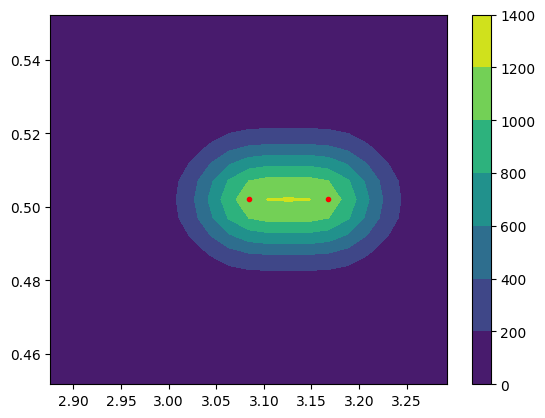

In [162]:
mu_in_chromato=projection.matrix_to_chromato(np.array([pt1, pt2]), time_rn, 1.25, chromato.shape)
plot.visualizer((chromato_TIC, time_rn), log_chromato=False, center_pt=[100,100], center_pt_window_1=10, center_pt_window_2=10, points=mu_in_chromato)

In [69]:
coordinates = peak_detection.peak_detection((chromato_TIC, time_rn, None), None, chromato_cube, 0, ABS_THRESHOLDS=0.01, method="peak_local_max", mode='3D', cluster=True)
print(coordinates, len(coordinates))
coordinates_in_chromato=projection.matrix_to_chromato(coordinates,time_rn, 1.25, chromato.shape)

[[101 100]] 1


In [121]:
similarity_threshold=0.001
blob1 = integration.peak_pool_similarity_check(chromato_TIC, np.array([pt1, pt2]), pt1, chromato_cube, threshold=0.5, plot_labels=True, similarity_threshold=similarity_threshold)
blob2 = integration.peak_pool_similarity_check(chromato_TIC, np.array([pt1, pt2]), pt2, chromato_cube, threshold=0.5, plot_labels=True, similarity_threshold=similarity_threshold)

In [163]:
print(integration.compute_area(chromato_TIC, blob1), integration.compute_area(chromato_TIC, blob2))

148958.17562192667 93133.72751593222


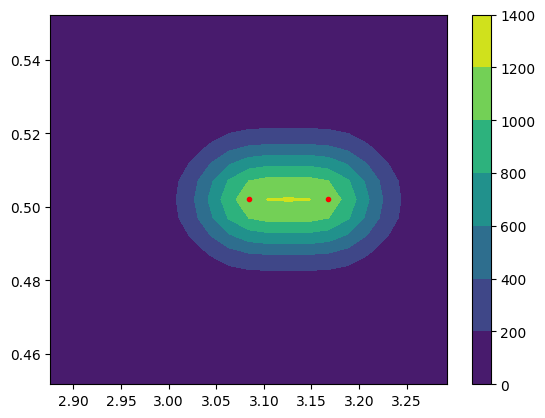

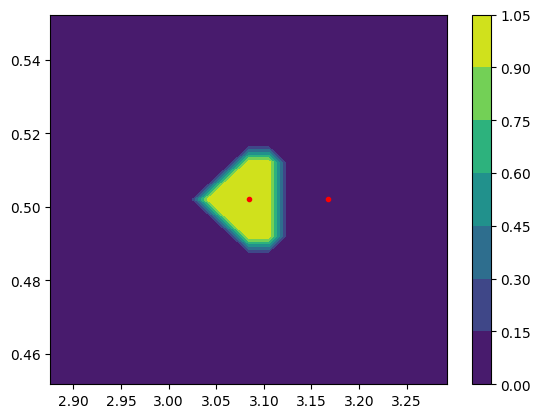

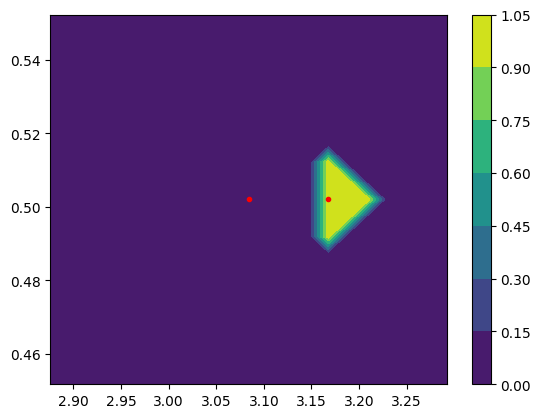

In [125]:
plot.visualizer((chromato_TIC, time_rn), log_chromato=False, center_pt=[100,100], center_pt_window_1=10, center_pt_window_2=10, points=mu_in_chromato)
plot.visualizer((blob1, time_rn), log_chromato=False, center_pt=[100,100], center_pt_window_1=10, center_pt_window_2=10, points=mu_in_chromato)
plot.visualizer((blob2, time_rn), log_chromato=False, center_pt=[100,100], center_pt_window_1=10, center_pt_window_2=10, points=mu_in_chromato)

In [129]:
importlib.reload(integration)
similarity_threshold=0.001
cds1 = integration.peak_pool_similarity_check_coordinates(chromato_TIC, np.array([pt1, pt2]), pt1, chromato_cube, threshold=0.3, plot_labels=True, similarity_threshold=similarity_threshold)
cds2 = integration.peak_pool_similarity_check_coordinates(chromato_TIC, np.array([pt1, pt2]), pt2, chromato_cube, threshold=0.3, plot_labels=True, similarity_threshold=similarity_threshold)
cds1_in_chromato=projection.matrix_to_chromato(cds1, time_rn, 1.25, chromato.shape)
cds2_in_chromato=projection.matrix_to_chromato(cds2, time_rn, 1.25, chromato.shape)

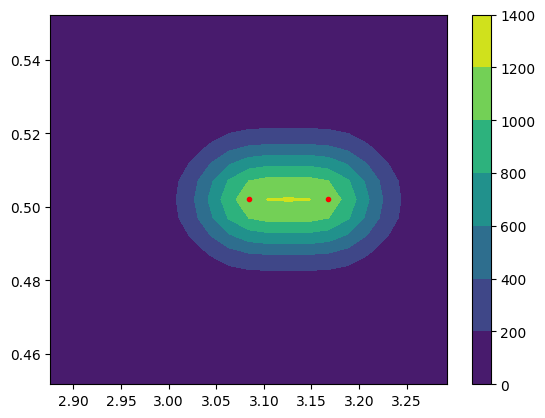

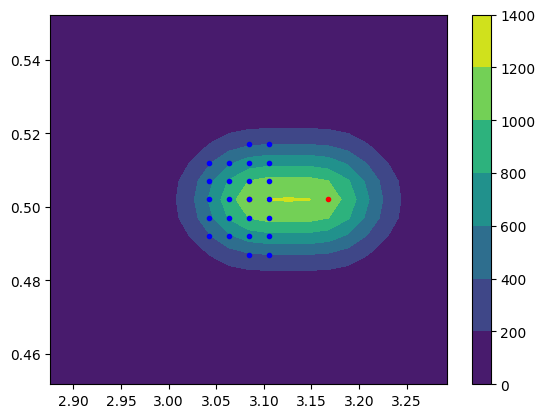

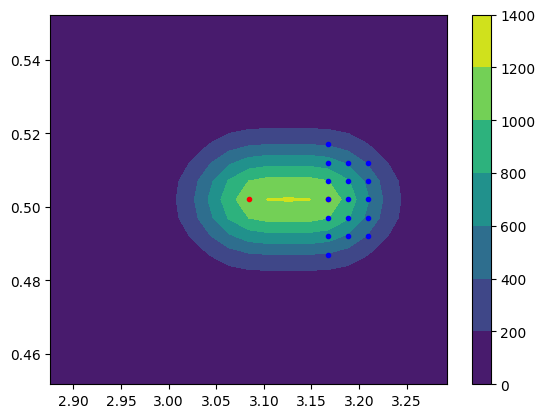

In [130]:
plot.visualizer((chromato_TIC, time_rn), log_chromato=False, center_pt=[100,100], center_pt_window_1=10, center_pt_window_2=10, points=mu_in_chromato)
plot.visualizer((chromato_TIC, time_rn), log_chromato=False, center_pt=[100,100], center_pt_window_1=10, center_pt_window_2=10, points=mu_in_chromato, contour=cds1_in_chromato)
plot.visualizer((chromato_TIC, time_rn), log_chromato=False, center_pt=[100,100], center_pt_window_1=10, center_pt_window_2=10, points=mu_in_chromato, contour=cds2_in_chromato)

no overlap test area

In [187]:
from matchms.importing import load_from_mgf, scores_from_json
import logging
from mass_spec import centroid_to_full_nominal

pt1=[100,100]

pt2=[110,100]

importlib.reload(peak_simulation)
logger=logging.getLogger('matchms')
logger.setLevel('ERROR')
lib_spectra=list(load_from_mgf("./lib_EIB.mgf"))[:]
spectrum1_obj=lib_spectra[0]
spectrum2_obj=lib_spectra[1]
range_min=min((np.min(spectrum1_obj.peaks.mz)), (np.min(spectrum2_obj.peaks.mz)))
range_max=max((np.max(spectrum1_obj.peaks.mz)), (np.max(spectrum2_obj.peaks.mz)))
range_min=int(round(range_min))
range_max=int(round(range_max))

new_mv=np.linspace(range_min, range_max, range_max-range_min+1)
new_iv=centroid_to_full_nominal((range_min, range_max), spectrum1_obj.peaks.mz, spectrum1_obj.peaks.intensities)
spectrum1=(new_mv,new_iv)
new_iv=centroid_to_full_nominal((range_min, range_max), spectrum2_obj.peaks.mz, spectrum2_obj.peaks.intensities)
spectrum2=(new_mv,new_iv)
size=20
chromato_cube = np.zeros((chromato.shape[0], chromato.shape[1], range_max-range_min+1))
print(chromato_cube.shape)
chromato_cube, area1 = peak_simulation.create_and_add_peak_spectrum(chromato_cube, size=size, intensity=1000, mu=pt1, spectrum=spectrum1[1], sigma=2)
chromato_cube, area2 = peak_simulation.create_and_add_peak_spectrum(chromato_cube, size=size, intensity=1000, mu=pt2, spectrum=spectrum2[1], sigma=2)

chromato_TIC=np.sum(chromato_cube, -1)
chromato_cube = np.moveaxis(chromato_cube, -1, 0)
print(area1, area2)

(2160, 250, 57)
3.720075976020837e-41
4.872338008392385e-39
4.969919882522615e-37
3.9480963805518994e-35
2.442600737740528e-33
1.1769109439216724e-31
4.4163257354165455e-30
1.290639565621842e-28
2.9374821117108028e-27
5.206811627928076e-26
7.18778173906099e-25
7.727593625528353e-24
6.470234925645459e-23
4.219123161617661e-22
2.1426475384166536e-21
8.474335404614781e-21
2.6102790696677054e-20
6.261733970585278e-20
1.1698459177061964e-19
1.7021157666886667e-19
1.928749847963918e-19
1.7021157666886667e-19
1.1698459177061964e-19
6.261733970585278e-20
2.6102790696677054e-20
8.474335404614781e-21
2.1426475384166536e-21
4.219123161617661e-22
6.470234925645459e-23
7.727593625528353e-24
7.18778173906099e-25
5.206811627928076e-26
2.9374821117108028e-27
1.290639565621842e-28
4.4163257354165455e-30
1.1769109439216724e-31
2.442600737740528e-33
3.9480963805518994e-35
4.969919882522615e-37
4.872338008392385e-39
3.720075976020837e-41
4.872338008392385e-39
6.381503448060793e-37
6.509310481390104e-35
5.

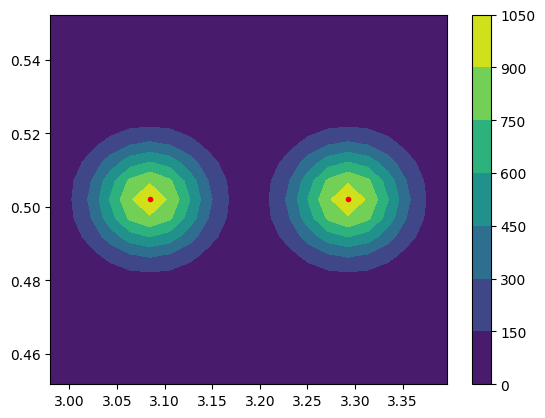

In [169]:
mu_in_chromato=projection.matrix_to_chromato(np.array([pt1, pt2]), time_rn, 1.25, chromato.shape)
plot.visualizer((chromato_TIC, time_rn), log_chromato=False, center_pt=[105,100], center_pt_window_1=10, center_pt_window_2=10, points=mu_in_chromato)

In [209]:
similarity_threshold=0.001
threshold=0.01
blob1 = integration.peak_pool_similarity_check(chromato_TIC, np.array([pt1, pt2]), pt1, chromato_cube, threshold=threshold, plot_labels=True, similarity_threshold=similarity_threshold)
blob2 = integration.peak_pool_similarity_check(chromato_TIC, np.array([pt1, pt2]), pt2, chromato_cube, threshold=threshold, plot_labels=True, similarity_threshold=similarity_threshold)

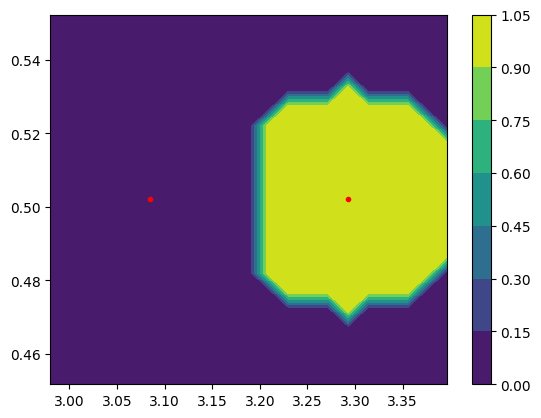

In [210]:
plot.visualizer((blob2, time_rn), log_chromato=False, center_pt=[105,100], center_pt_window_1=10, center_pt_window_2=10, points=mu_in_chromato)

In [211]:
len(chromato_TIC[np.argwhere(blob1 != 0)]), len(np.argwhere(blob1 != 0))

(105, 105)

In [212]:
cds=np.argwhere(blob1 != 0)
print(np.sum(chromato_TIC[cds[:,0],cds[:,1]]))
cds=np.argwhere(blob2 != 0)
print(np.sum(chromato_TIC[cds[:,0],cds[:,1]]))

24701.178298405994
24701.17829840599


In [213]:
np.sum(chromato_TIC[np.argwhere(blob1 != 0)]), np.sum(chromato_TIC[np.argwhere(blob2 != 0)])

(534911.5091520941, 534911.5091520941)

In [206]:
chromato_TIC[np.argwhere(blob1 != 0)].shape

(61, 2, 250)

In [184]:
similarity_threshold=0.001
cds1 = integration.peak_pool_similarity_check_coordinates(chromato_TIC, np.array([pt1, pt2]), pt1, chromato_cube, threshold=threshold, plot_labels=True, similarity_threshold=similarity_threshold)
cds2 = integration.peak_pool_similarity_check_coordinates(chromato_TIC, np.array([pt1, pt2]), pt2, chromato_cube, threshold=threshold, plot_labels=True, similarity_threshold=similarity_threshold)
cds1_in_chromato=projection.matrix_to_chromato(cds1, time_rn, 1.25, chromato.shape)
cds2_in_chromato=projection.matrix_to_chromato(cds2, time_rn, 1.25, chromato.shape)

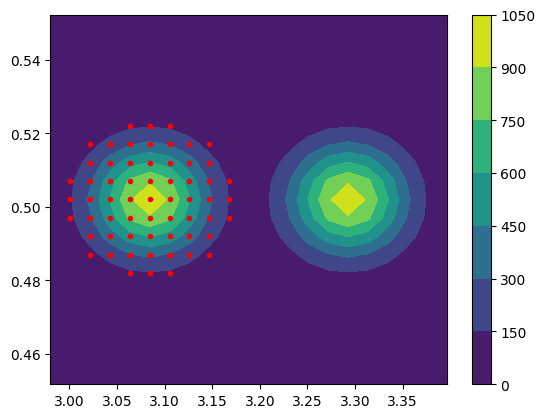

In [185]:
plot.visualizer((chromato_TIC, time_rn), log_chromato=False, center_pt=[105,100], center_pt_window_1=10, center_pt_window_2=10, points=cds1_in_chromato)

In [216]:
importlib.reload(integration)
print(integration.compute_area(chromato_TIC, blob1), integration.compute_area(chromato_TIC, blob2))
print(area1, area2)

24701.178298405994 24701.17829840599
25132.74122871835 25132.74122871835


# Maximum Filter

In [131]:
from skimage.morphology import binary_dilation
import benchmark_metrics

In [132]:
peaks_gt, gt_cmp=benchmark_metrics.compute_gt("G:/SIMULATION/noisy_simulation_strong_overlap.json", chromato_obj)

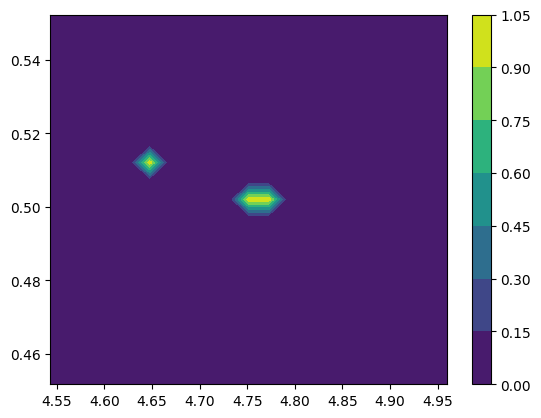

In [150]:
plot.visualizer((peaks_gt, time_rn), log_chromato=False, center_pt=[180,100], center_pt_window_1=10, center_pt_window_2=10)

In [139]:
np.unique(peaks_gt)

masked_array(data=[0., 1.],
             mask=False,
       fill_value=1e+20)

In [156]:
peaks_gt_dilated=np.where(binary_dilation(peaks_gt, footprint=None, out=None) == True, 1, 0)

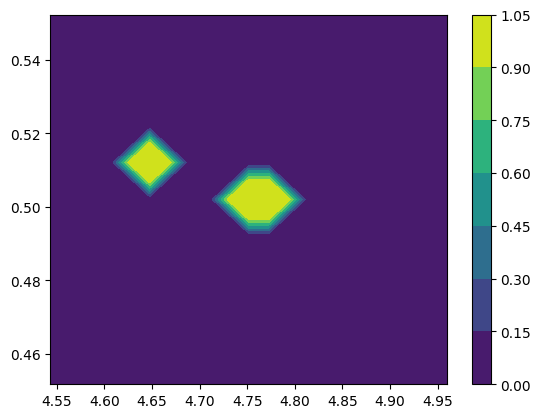

In [157]:
plot.visualizer((peaks_gt_dilated, time_rn), log_chromato=False, center_pt=[180,100], center_pt_window_1=10, center_pt_window_2=10)

# Test identification simulation

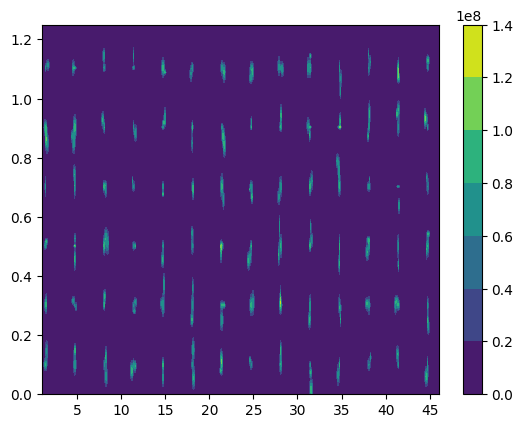

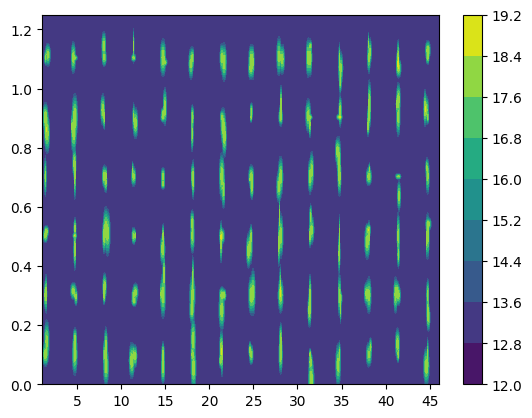

In [63]:
chromato_obj=read_chroma.read_chroma('G:/SIMULATION/noisy_simulation_weak_overlap.cdf',mod_time= 1.25)
chromato, time_rn, spectra_obj=chromato_obj
plot.visualizer(chromato_obj=(chromato,time_rn), log_chromato=False)
plot.visualizer(chromato_obj=(chromato,time_rn))

In [147]:
(l1, l2, mv, iv, range_min, range_max) = spectra_obj

In [64]:
full_spectra = mass_spec.read_full_spectra_centroid(spectra_obj=spectra_obj)

--- 445.56348490715027 seconds --- to compute full spectra centroid


In [65]:
spectra, debuts, fins = full_spectra
chromato_cube = read_chroma.full_spectra_to_chromato_cube(full_spectra=full_spectra, spectra_obj=spectra_obj)
chromato = baseline_correction.chromato_no_baseline(chromato)
chromato_cube = np.array(baseline_correction.chromato_cube_corrected_baseline(chromato_cube))
sigma = estimate_sigma(chromato, channel_axis=None)
MIN_SEUIL = 5 * sigma * 100 / np.max(chromato)

In [88]:
coordinates = peak_detection.peak_detection((chromato, time_rn, spectra_obj), spectra, chromato_cube, MIN_SEUIL, ABS_THRESHOLDS=None, method="peak_local_max", mode='tic', cluster=True)
len(coordinates)

269

In [89]:
coordinates_in_chromato = projection.matrix_to_chromato(coordinates, time_rn, 1.25, chromato.shape)

In [98]:
data_json=benchmark_metrics.read_chromato_gt_json('G:/SIMULATION/noisy_simulation_weak_overlap.json')
gt_peaks=[]
for i, cluster in enumerate(data_json['peaks_mu']):
    for j, peaks in enumerate(cluster):
        gt_peaks.append([peaks[0], peaks[1]])
gt_peaks=np.array(gt_peaks)
gt_peaks_in_chromato=projection.matrix_to_chromato(gt_peaks, time_rn, 1.25, chromato.shape)

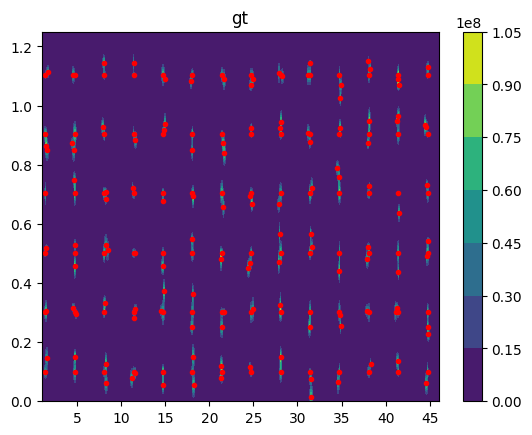

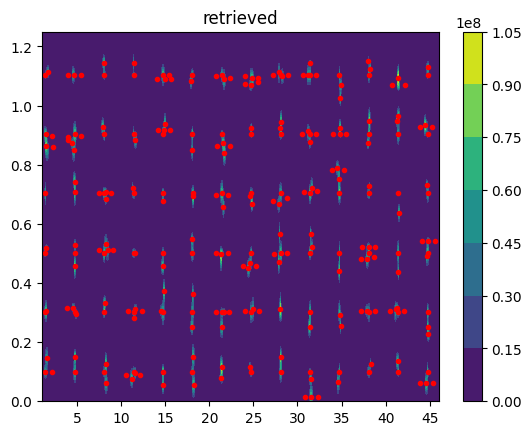

c:\Users\Stan\pic\plot.py:356: RuntimeWarning: divide by zero encountered in log
  chromato = np.log(chromato)


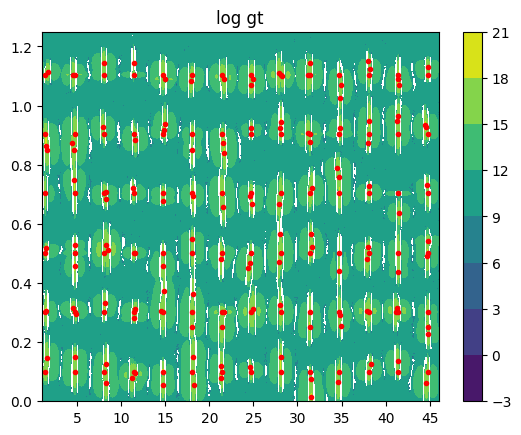

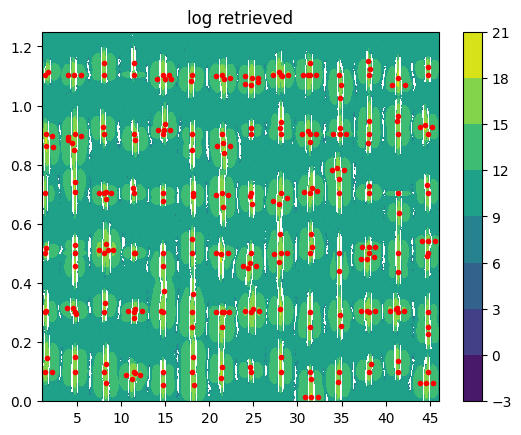

In [102]:
plot.visualizer((chromato, time_rn), points=gt_peaks_in_chromato, log_chromato=False, title="gt")
plot.visualizer((chromato, time_rn), points=coordinates_in_chromato, log_chromato=False, title="retrieved")
plot.visualizer((chromato, time_rn), points=gt_peaks_in_chromato, title="log gt")
plot.visualizer((chromato, time_rn), points=coordinates_in_chromato, title="log retrieved")

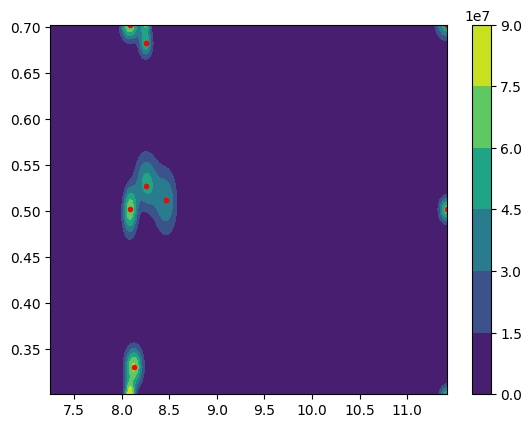

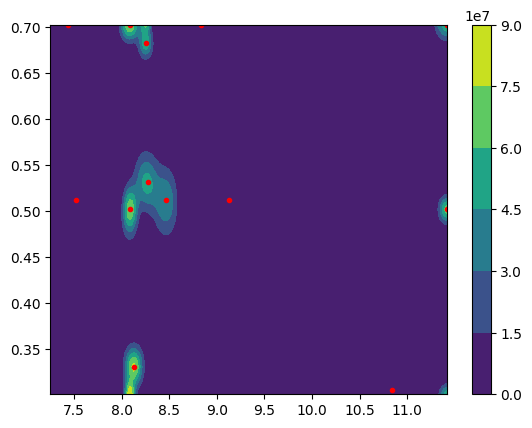

c:\Users\Stan\pic\plot.py:356: RuntimeWarning: divide by zero encountered in log
  chromato = np.log(chromato)


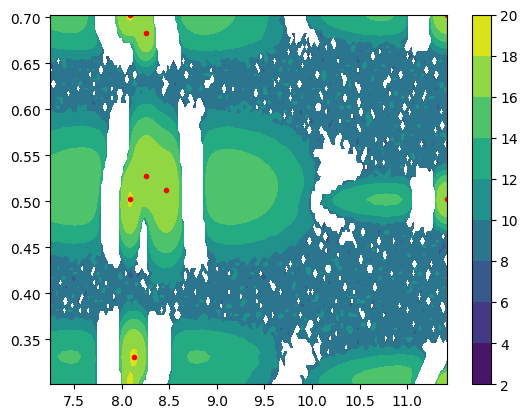

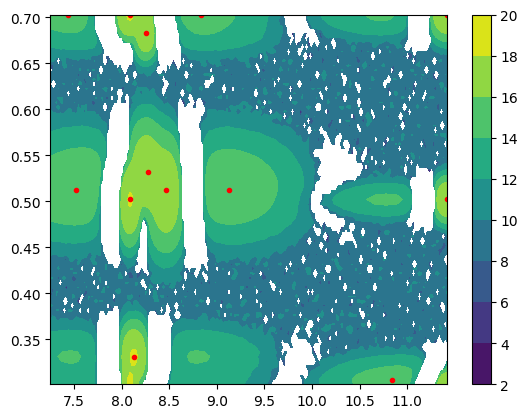

In [105]:
plot.visualizer((chromato, time_rn), points=gt_peaks_in_chromato, center_pt=[400,100], center_pt_window_1=100, center_pt_window_2=40, log_chromato=False)
plot.visualizer((chromato, time_rn), points=coordinates_in_chromato, center_pt=[400,100], center_pt_window_1=100, center_pt_window_2=40, log_chromato=False)
plot.visualizer((chromato, time_rn), points=gt_peaks_in_chromato, center_pt=[400,100], center_pt_window_1=100, center_pt_window_2=40)
plot.visualizer((chromato, time_rn), points=coordinates_in_chromato, center_pt=[400,100], center_pt_window_1=100, center_pt_window_2=40)

In [107]:
matches = matching.matching_nist_lib_from_chromato_cube((chromato, time_rn, spectra_obj), chromato_cube, coordinates, mod_time = 1.25, hit_prob_min=0, match_factor_min=0)

nb_peaks:  269


c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string 2-Isopropyl-5-methylcyclohexanol, (1�,2�,5�)-: [-32, -32, -32].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-Butyrolactone: [-25].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_search\utils.py:123: UserWarning: Unable to parse the following character codes for string �-BL: [-25].
  warnings.warn(f"Unable to parse the following character codes for string {hit_name}: {errors}.")
c:\Users\Stan\AppData\Local\Programs\Python\Python38\lib\site-packages\pyms_nist_searc

nb match:
269


c:\Users\Stan\pic\matching.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(match)


In [189]:
importlib.reload(benchmark_metrics)
retrieved_peaks, retrieved_cmp, retrieved_peaks_area=benchmark_metrics.read_peak_table('G:/SIMULATION/noisy_peak_tables/noisy_weak_overlap_peak_local_max_tic_cluster_True.csv', chromato_obj)
peaks_gt, gt_cmp, peaks_gt_dilated=benchmark_metrics.compute_gt('G:/SIMULATION/noisy_simulation_weak_overlap.json', chromato_obj)

In [191]:
len(np.argwhere((retrieved_cmp==gt_cmp) & (gt_cmp != ''))) / len(np.argwhere(gt_cmp != ''))

0.7219512195121951

In [192]:
import logging
from matchms.importing import load_from_mgf, scores_from_json
logger=logging.getLogger('matchms')
logger.setLevel('ERROR')
lib_spectra=list(load_from_mgf("./lib_EIB_gt.mgf"))[:]

In [173]:
def search_spectrum_by_metadata(lib_spectra, id):
    for spectum_obj in lib_spectra:
        if (spectum_obj.metadata['compound_name'] == id):
            return spectum_obj.peaks.mz, spectum_obj.peaks.intensities
    print('NO REF', id)
    return None

In [179]:
sims=[]
mv=np.linspace(range_min, range_max, range_max - range_min + 1).astype(int)
for cd in np.argwhere(gt_cmp != ''):
    data_spectrum_iv=mass_spec.read_spectrum_from_chromato_cube(cd, chromato_cube)
    lib_spectrum=search_spectrum_by_metadata(lib_spectra, gt_cmp[cd[0], cd[1]])
    if (lib_spectrum == None):
        continue
    try:
        lib_spectrum_full_nominal=mass_spec.centroid_to_full_nominal((range_min, range_max), lib_spectrum[0], lib_spectrum[1])
        sim=utils.compute_spectra_similarity((mv, data_spectrum_iv), (mv, lib_spectrum_full_nominal))
    except:
        print('err')
        continue
    print(retrieved_peaks[cd[0], cd[1]], '---' ,peaks_gt[cd[0], cd[1]], '/', retrieved_cmp[cd[0], cd[1]], '---' ,gt_cmp[cd[0], cd[1]])
    print(sim)
    sims.append(sim)
sims=np.array(sims)

0.0 --- 1.0 /  --- Ethyl Vanillin
0.9611004340756768
1.0 --- 1.0 / Benzoic acid, 2-hydroxy-, ethyl ester --- Hexanoic acid, methyl ester
0.9211970243012676
1.0 --- 1.0 / ortho-Methoxyacetophenone --- Benzoic acid, hexyl ester
0.9440007751931989
0.0 --- 1.0 /  --- 2-Furanmethanol, acetate
0.9904481316537023
1.0 --- 1.0 / 5-Acetyl-2,4-dimethylthiazole --- Î±-Methylstyrene
0.9991297718546259
1.0 --- 1.0 / Cyclohexanecarboxylic acid, methyl ester --- Benzaldehyde, 3-hydroxy-
0.9999892489424279
0.0 --- 1.0 /  --- Ethylenediamine
0.9864098222624212
0.0 --- 1.0 /  --- Pentadecane
0.9891927079353318
0.0 --- 1.0 /  --- Diisopropyl adipate
0.9824729604669445
0.0 --- 1.0 /  --- Acetylacetone
0.9112296704953657
0.0 --- 1.0 /  --- 2,6-Xylidine
0.963832534606605
0.0 --- 1.0 /  --- Butanoic acid, 3-methyl-, 2-phenylethyl ester
0.9985989793059812
0.0 --- 1.0 /  --- 5-Methylhexanoic acid
0.999425604470072
0.0 --- 1.0 /  --- Benzene, 1,4-dimethoxy-
0.9944063735618429
0.0 --- 1.0 /  --- 1-Butanol
0.91766

In [180]:
len(np.argwhere((retrieved_peaks==peaks_gt) & (peaks_gt != 0))) / len(np.argwhere(gt_cmp != ''))

0.13658536585365855

In [176]:
np.argwhere((retrieved_cmp==gt_cmp) & (gt_cmp != ''))

array([], shape=(0, 2), dtype=int64)

In [ ]:
np.argwhere(gt_cmp != '')

Benchmark Area

In [8]:
import benchmark_metrics

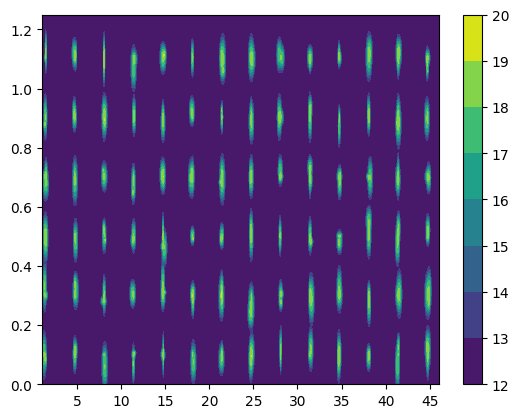

In [9]:
chromato_obj=read_chroma.read_chroma("G:/SIMULATION/simulation_strong_overlap.cdf")
chromato, time_rn, spectra_obj=chromato_obj
plot.visualizer((chromato, time_rn))

In [16]:
importlib.reload(benchmark_metrics)
retrieved_peaks, retrieved_cmp, retrieved_peaks_area=benchmark_metrics.read_peak_table("G:/SIMULATION/noisy_loc/loc_2000_DoG_3D_cluster_True.csv", chromato_obj)
peaks_gt, gt_cmp, peaks_gt_dilated,area_gt=benchmark_metrics.compute_gt("G:/SIMULATION/loc_2000_scale_500_poisson_09.json", chromato_obj)

In [21]:
a=np.argwhere((retrieved_peaks == peaks_gt) & (peaks_gt != 0))

In [33]:
for i in range(10):
    print(retrieved_peaks_area[a[i,0], a[i,1]], area_gt[a[i,0], a[i,1]], abs(retrieved_peaks_area[a[i,0], a[i,1]] - area_gt[a[i,0], a[i,1]]))

2643933043.063738 9316409898.441805 6672476855.378067
1301731896.263554 2013384900.5549889 711653004.2914348
175430441.0093403 2970767146.3197412 2795336705.310401
889425506.477581 6107820549.947945 5218395043.470364
400646381.8870091 2093016248.581612 1692369866.694603
93779875.39241102 5721911376.322106 5628131500.929695
204242954.7081183 2565840357.9089656 2361597403.200847
140557593.7822739 10145715905.929731 10005158312.147457
123123709.4433001 2697167414.94108 2574043705.49778
159941408.51680267 2092925309.8447175 1932983901.3279147


In [27]:
retrieved_peaks_area[a[:,0], a[:,1]] - area_gt[a[:,0], a[:,1]] 

masked_array(data=[-6.67247686e+09, -7.11653004e+08, -2.79533671e+09,
                   -5.21839504e+09, -1.69236987e+09, -5.62813150e+09,
                   -2.36159740e+09, -1.00051583e+10, -2.57404371e+09,
                   -1.93298390e+09, -5.41606576e+09, -3.32549397e+09,
                   -6.38681946e+09, -1.09300502e+09, -2.57105992e+09,
                   -1.25784412e+09, -1.20223859e+09, -9.13684137e+09,
                   -6.88457650e+09, -2.96606148e+09, -6.69143882e+09,
                   -4.05078087e+09, -1.46932678e+09, -3.66845228e+09,
                   -1.12259753e+09, -7.29581430e+08, -6.52848517e+09,
                   -1.17956529e+09, -1.29794872e+09, -3.25888244e+09,
                   -1.19609446e+09, -1.77214955e+09, -2.67379856e+08,
                   -8.84487351e+08, -7.43027420e+09, -3.14327418e+09,
                   -2.77927901e+09, -1.23262417e+09, -2.74656389e+09,
                   -1.59236966e+09, -4.89008245e+09, -6.69739784e+09,
                   -

In [28]:
np.sum(np.abs(retrieved_peaks_area[a[:,0], a[:,1]] - area_gt[a[:,0], a[:,1]])) / len(a)

3066750443.037266

# OPEN SIMU CDF

In [20]:
import netCDF4 as nc


In [32]:
ds_simu = nc.Dataset('G:/SIMULATION/loc_2000_scale_500_poisson_21_overlap_07_099.cdf')

In [38]:
ds_centroid = nc.Dataset('G:/ELO_CDF/liquide-cdf-centroid/G0-1-201222.cdf')

In [39]:
ds = nc.Dataset('./data/G0-1-250123.cdf')

In [35]:
ds_simu

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dataset_completeness: C1+C2
    ms_template_revision: 1.0.1
    netcdf_revision: 3.6.3
    languages: English
    netcdf_file_date_time_stamp: 20230322164910+0100
    experiment_date_time_stamp: 20230315151810+0100
    experiment_type: Centroided Mass Spectrum
    sample_state: Other State
    test_separation_type: Gas-Liquid Chromatography
    test_ms_inlet: Capillary Direct
    test_ionization_mode: Electron Impact
    test_ionization_polarity: Positive Polarity
    test_detector_type: Electron Multiplier
    test_resolution_type: Constant Resolution
    test_scan_function: Mass Scan
    test_scan_direction: Up
    test_scan_law: Linear
    raw_data_mass_format: Double
    raw_data_time_format: Short
    raw_data_intensity_format: Double
    units: Seconds
    starting_scan_number: 0
    dimensions(sizes): _2_byte_string(2), _4_byte_string(4), _8_byte_string(8), _16_byte_string(16), _32_byte_str

In [40]:
ds_centroid

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dataset_completeness: C1+C2
    ms_template_revision: 1.0.1
    netcdf_revision: 3.6.3
    languages: English
    netcdf_file_date_time_stamp: 20230307215458+0100
    experiment_date_time_stamp: 20221220195302+0100
    experiment_type: Centroided Mass Spectrum
    sample_state: Other State
    test_separation_type: Gas-Liquid Chromatography
    test_ms_inlet: Capillary Direct
    test_ionization_mode: Electron Impact
    test_ionization_polarity: Positive Polarity
    test_detector_type: Electron Multiplier
    test_resolution_type: Constant Resolution
    test_scan_function: Mass Scan
    test_scan_direction: Up
    test_scan_law: Linear
    raw_data_mass_format: Double
    raw_data_time_format: Short
    raw_data_intensity_format: Double
    units: Seconds
    starting_scan_number: 0
    dimensions(sizes): _2_byte_string(2), _4_byte_string(4), _8_byte_string(8), _16_byte_string(16), _

In [31]:
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dataset_completeness: C1+C2
    ms_template_revision: 1.0.1
    netcdf_revision: 3.6.3
    languages: English
    netcdf_file_date_time_stamp: 20230126090338+0100
    experiment_date_time_stamp: 20230125120639+0100
    experiment_type: Centroided Mass Spectrum
    sample_state: Other State
    test_separation_type: Gas-Liquid Chromatography
    test_ms_inlet: Capillary Direct
    test_ionization_mode: Electron Impact
    test_ionization_polarity: Positive Polarity
    test_detector_type: Electron Multiplier
    test_resolution_type: Constant Resolution
    test_scan_function: Mass Scan
    test_scan_direction: Up
    test_scan_law: Linear
    raw_data_mass_format: Short
    raw_data_time_format: Short
    raw_data_intensity_format: Float
    units: Seconds
    starting_scan_number: 0
    dimensions(sizes): _2_byte_string(2), _4_byte_string(4), _8_byte_string(8), _16_byte_string(16), _32

In [36]:
ds_simu["mass_values"][:20]

masked_array(data=[ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
                   15., 16., 17., 18., 19., 21., 22., 23., 24.],
             mask=False,
       fill_value=1e+20)

In [37]:
ds["mass_values"][:20]

masked_array(data=[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
                   54, 55, 56, 57, 58, 59],
             mask=False,
       fill_value=999999,
            dtype=int16)